# Modeling of Telecommunication CDRs to identify network usage patterns

In [1]:
#import frequently used modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Set style for the notebook
sns.set()

# DATA WRANGLING

In [3]:
#Initialize an empty dataframe to append daily and hourly resampled data
dailyGridActivity = pd.DataFrame()
hourlyGridActivity = pd.DataFrame()

#Create a list of 62 data file names placed under directory  "./Data/" with extension .txt
import glob
filenames = glob.glob("Data/*.txt")

#Set the column names for the data read
col_list = ['gridID', 'timeInterval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internet']

#Read each tab separated file into Pandas DataFrame 
for file in filenames:
    read_data = pd.read_csv(file, sep='\t',header=None, names=col_list, parse_dates=True)
    
    #Convert timeInterval column which has Epoch timestamps to UTC and then convert to Milan's local timezone and save it to column startTime
    #tz_localize(None) returns local time format instead of "UTC+1:00" format
    read_data['startTime'] = pd.to_datetime(read_data.timeInterval, unit='ms', utc=True).dt.tz_convert('CET').dt.tz_localize(None)
    
    #Drop timeInterval & countryCode columns
    read_data.drop(columns=['timeInterval','countryCode'], inplace=True)
    
    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to daily aggregation 
    read_data_daily = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='D')]).sum()
    dailyGridActivity = pd.concat([dailyGridActivity,read_data_daily]).groupby(['gridID', 'startTime']).sum()
    
    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to hourly aggregation 
    read_data_hourly = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='H')]).sum()
    hourlyGridActivity = pd.concat([hourlyGridActivity,read_data_hourly]).groupby(['gridID', 'startTime']).sum()
    
#Get Grid wise total volume of the activities over the 2months
totalGridActivity = dailyGridActivity.groupby('gridID').sum()


In [4]:
#Sample of format of each line as read from the input file
read_data = pd.read_csv('Data/sms-call-internet-mi-2013-11-01.txt', sep='\t',header=None, names=col_list, parse_dates=True)
read_data.head(100)

,gridID,timeInterval,countryCode,smsIn,smsOut,callIn,callOut,internet
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963
...,...,...,...,...,...,...,...,...
95,1,1383293400000,39,0.178811,0.249364,0.407891,0.483438,11.383994
96,1,1383293400000,7,NaN,0.001787,NaN,NaN,NaN
97,1,1383294000000,0,0.033287,NaN,NaN,NaN,NaN
98,1,1383294000000,39,0.515391,0.388950,0.521830,0.438851,10.905550


In [5]:
#Resampling by hour
hourlyGridActivity.head(1493)

smsIn    smsOut    callIn   callOut   internet
gridID startTime                                                             
1      2013-11-01 00:00:00  2.084285  1.104749  0.591930  0.429290  57.799009
       2013-11-01 01:00:00  1.163624  0.770031  0.190564  0.194139  44.046899
       2013-11-01 02:00:00  0.415579  0.300391  0.027925  0.135964  41.207149
       2013-11-01 03:00:00  1.152067  0.895724  0.001787  0.026137  33.022070
       2013-11-01 04:00:00  0.354453  0.511192  0.005362  0.026137  31.376930
...                              ...       ...       ...       ...        ...
2      2013-11-01 00:00:00  2.091501  1.087979  0.602031  0.438173  57.914858
       2013-11-01 01:00:00  1.178439  0.773207  0.192136  0.193979  44.151457
       2013-11-01 02:00:00  0.415258  0.302315  0.028278  0.137535  41.329761
       2013-11-01 03:00:00  1.151394  0.902170  0.000922  0.027356  33.078556
       2013-11-01 04:00:00  0.357948  0.520075  0.002765  0.027356  31.453361

[1493 rows x 5 columns]

In [6]:
#Resampling by Day
dailyGridActivity.head(65)

smsIn     smsOut     callIn    callOut     internet
gridID startTime                                                           
1      2013-11-01   78.709755  45.886570  41.108567  48.245378  1507.048349
       2013-11-02   86.415810  43.875946  47.891016  53.590637  1515.641856
       2013-11-03   77.728292  45.446780  36.145436  40.906425  1533.148425
       2013-11-04  104.793806  54.821018  67.898464  70.399418  1404.813593
       2013-11-05   97.425105  46.607029  68.735213  70.766221  1518.090111
...                       ...        ...        ...        ...          ...
       2013-12-31  124.049269  85.569336  58.372156  63.266368  1376.737573
       2014-01-01  126.893711  96.486508  43.109098  54.512429  1532.564428
2      2013-11-01   79.846206  46.480586  41.741924  49.136913  1512.859757
       2013-11-02   87.738546  44.512066  48.636353  54.521711  1522.727906
       2013-11-03   78.740671  45.881772  36.713980  41.584801  1539.831167

[65 rows x 5 columns]

In [7]:
#Total volume os activities over 2 months
totalGridActivity.head(10)

,smsIn,smsOut,callIn,callOut,internet
gridID,,,,,
1,6178.894730,3358.842325,3805.892719,3991.422048,92992.666580
2,6267.021008,3402.658923,3861.301592,4052.842143,93368.388389
3,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391
4,5923.635378,3231.926757,3645.399918,3813.517635,91904.381588
5,5522.707656,3017.566898,3401.745307,3568.366951,83630.697355
6,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391
7,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391
8,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391
9,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391


In [8]:
#Create additional columns hours:hour of the day, weekdayFlag: weekend or weekday information
dailyGridActivity['weekdayFlag'] = dailyGridActivity.index.get_level_values(1)
dailyGridActivity['weekdayFlag'] = dailyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['weekdayFlag'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['weekdayFlag'] = hourlyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['hours'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['hours'] = hourlyGridActivity['hours'].dt.hour

dailyGridActivity['sms'] = dailyGridActivity['smsIn'] + dailyGridActivity['smsOut']
dailyGridActivity['call'] = dailyGridActivity['callIn'] + dailyGridActivity['callOut']

hourlyGridActivity['sms'] = hourlyGridActivity['smsIn'] + hourlyGridActivity['smsOut']
hourlyGridActivity['call'] = hourlyGridActivity['callIn'] + hourlyGridActivity['callOut']

totalGridActivity['sms'] = totalGridActivity['smsIn']+totalGridActivity['smsOut']
totalGridActivity['call'] = totalGridActivity['callIn']+totalGridActivity['callOut']

# EDA

### Geographical visualization of 10000 grids from the geojson file

In [9]:
#import geopandas and geojsonio modules to visualize the geojson file that contains 
#spatially aggreagted 10000 grids for city of Milan
#Note: There is some buffering trouble and file doesnot open in the browser automatically. 
#It needs to be loaded manually using "Open" -> "File" menu option in the geojson browser 
#that pops up on running the code below
import geopandas
import geojsonio
milan = geopandas.read_file('Data/milano-grid.geojson')
milan_json = milan.to_json()
_ = geojsonio.display(milan_json)

![title](images/City_of_Milan.png)

### Top 10 Grids

In [10]:
#Sort grids by total volumes of SMS, Call & Internet activities
smsGridActivity = totalGridActivity[['sms']].sort_values(by = 'sms',ascending=False)
callGridActivity = totalGridActivity[['call']].sort_values(by = 'call',ascending=False)
internetGridActivity = totalGridActivity[['internet']].sort_values(by = 'internet',ascending=False)
#Fetch the top 10 grids from the sorted grids and display them
top10 = pd.DataFrame()
top10['sms'] = smsGridActivity[:10].index.values
top10['call'] = callGridActivity[:10].index.values
top10['internet'] = internetGridActivity[:10].index.values
top10

,sms,call,internet
0,5059,5059,5161
1,5161,6064,5059
2,6064,5161,5259
3,5061,5159,5061
4,5159,5061,5258
5,5259,5259,5159
6,5262,6165,6064
7,4855,5262,4855
8,4856,6058,4856
9,6165,5162,5262


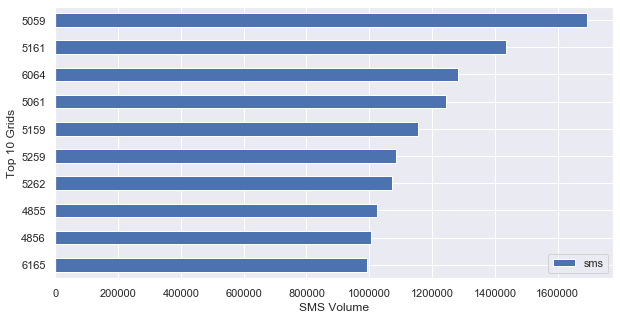

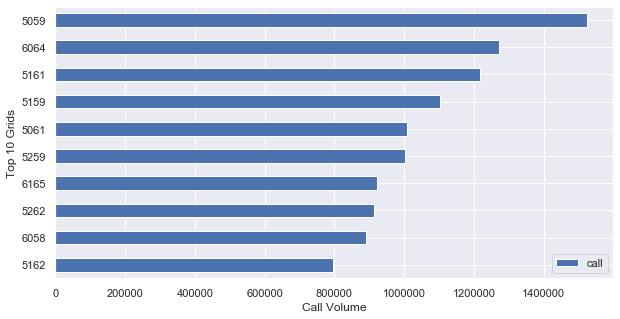

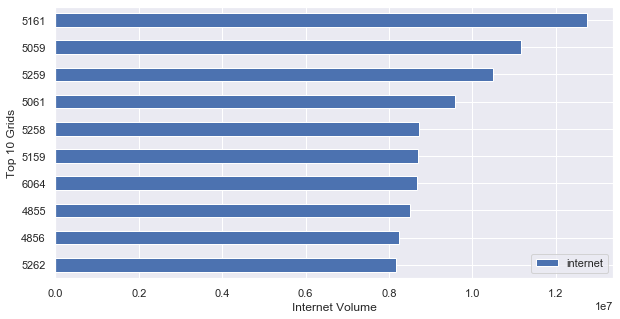

In [11]:
#Plot top 10 grids and its volume for SMS activity
ax = smsGridActivity[:10].plot(kind='barh', figsize=(10,5))
ax.invert_yaxis()
ax.set_xlabel("SMS Volume")
ax.set_ylabel("Top 10 Grids")

#Plot top 10 grids and its volume for Call activity
ax = callGridActivity[:10].plot(kind='barh', figsize=(10,5))
ax.invert_yaxis()
ax.set_xlabel("Call Volume")
ax.set_ylabel("Top 10 Grids")

#Plot top 10 grids and its volume for Internet activity
ax = internetGridActivity[:10].plot(kind='barh', figsize=(10,5))
ax.invert_yaxis()
ax.set_xlabel("Internet Volume")
ax.set_ylabel("Top 10 Grids")
plt.show()

### Mapping top Grids with real geographic locations

In [12]:
#Display only top 10 grids from the geojson file
milan = geopandas.read_file('Data/milano-grid.geojson')
#get unique values across all the columns in dataframe top10
topgrids = pd.unique(top10.values.ravel())

#New browser opens with the top 10 grids
topGridgeojson = milan.loc[milan['cellId'].isin(topgrids)]
topGridgeojson = topGridgeojson.to_json()
_ = geojsonio.display(topGridgeojson)

![title](images/Top_10_geojson.png)

In [13]:
#get the daily volumes for the top 10 grids
daily5059 = dailyGridActivity.loc[5059][['sms','call','internet']]
daily5161 = dailyGridActivity.loc[5161][['sms','call','internet']]
daily6064 = dailyGridActivity.loc[6064][['sms','call','internet']]
daily5259 = dailyGridActivity.loc[5259][['sms','call','internet']]
daily5061 = dailyGridActivity.loc[5061][['sms','call','internet']]
daily5159 = dailyGridActivity.loc[5159][['sms','call','internet']]
daily5258 = dailyGridActivity.loc[5258][['sms','call','internet']]
daily5262 = dailyGridActivity.loc[5262][['sms','call','internet']]
daily6165 = dailyGridActivity.loc[6165][['sms','call','internet']]
daily4855 = dailyGridActivity.loc[4855][['sms','call','internet']]
daily4856 = dailyGridActivity.loc[4856][['sms','call','internet']]
daily6058 = dailyGridActivity.loc[6058][['sms','call','internet']]
daily5162 = dailyGridActivity.loc[5162][['sms','call','internet']]

### SMS, Call, Internet activity comparison in top grids

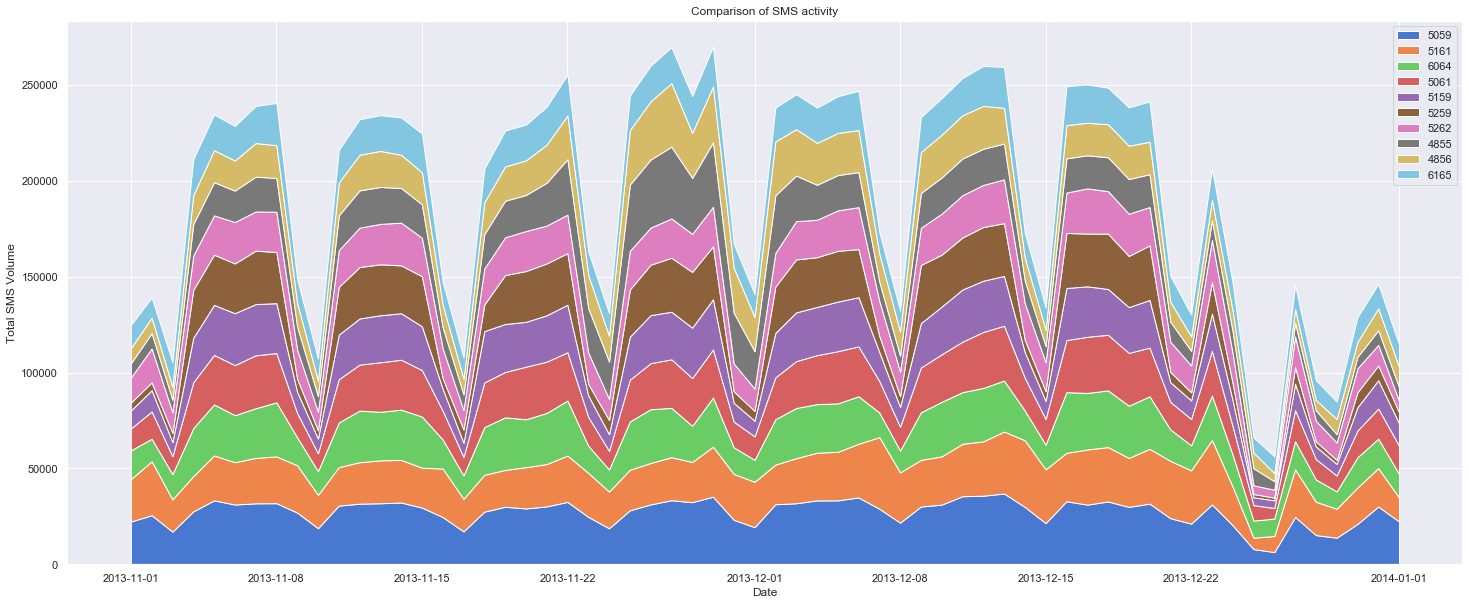

In [14]:
#Plot daily SMS activity for top 10 grids from Nov 1, 2013 to Jan 1, 2014
col = sns.color_palette("muted")
plt.figure(figsize=(25,10))
ax = plt.stackplot(daily5059.index, daily5059.sms, daily5161.sms,daily6064.sms, daily5061.sms, 
                   daily5159.sms, daily5259.sms, daily5262.sms, daily4855.sms, daily4856.sms,
                   daily6165.sms, labels = top10['sms'], colors=col)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total SMS Volume')
plt.title('Comparison of SMS activity')
plt.show()

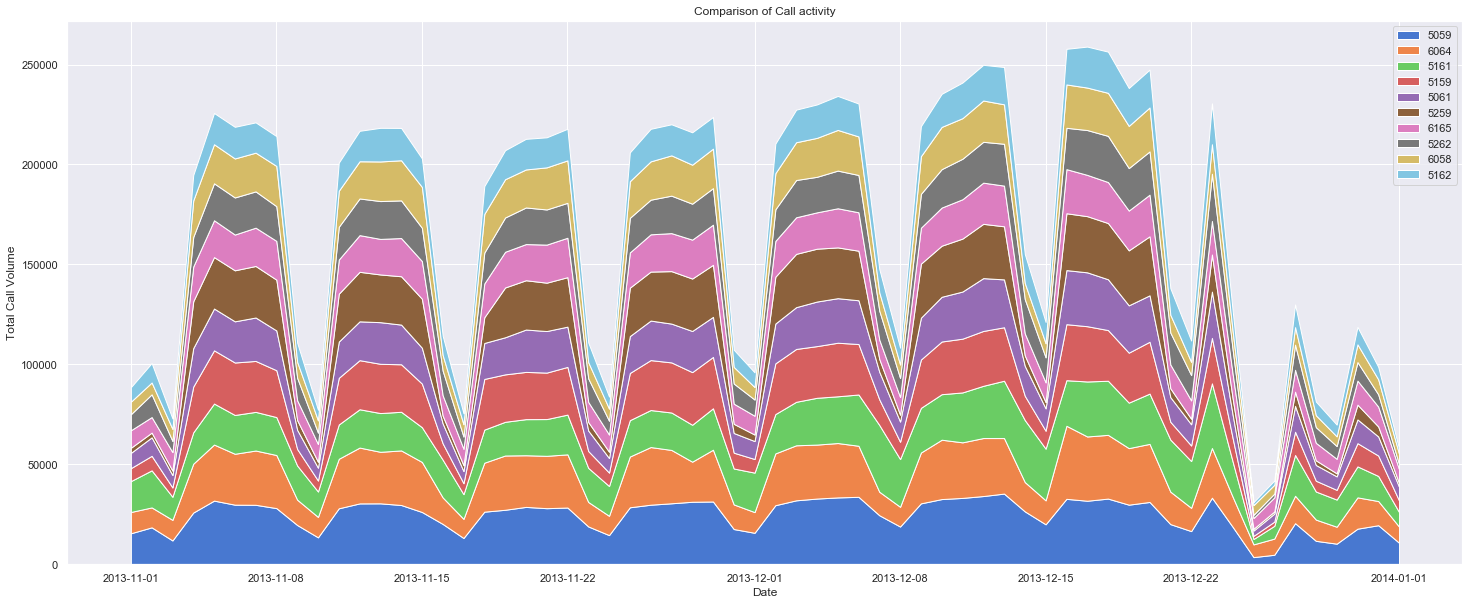

In [15]:
#Plot daily Call activity for top 10 grids from Nov 1, 2013 to Jan 1, 2014
plt.figure(figsize=(25,10))
ax = plt.stackplot(daily5059.index, daily5059.call, daily6064.call, daily5161.call, daily5159.call, 
                   daily5061.call, daily5259.call, daily6165.call, daily5262.call, daily6058.call,
                   daily5162.call,labels = top10['call'],colors=col)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Call Volume')
plt.title('Comparison of Call activity')
plt.show()

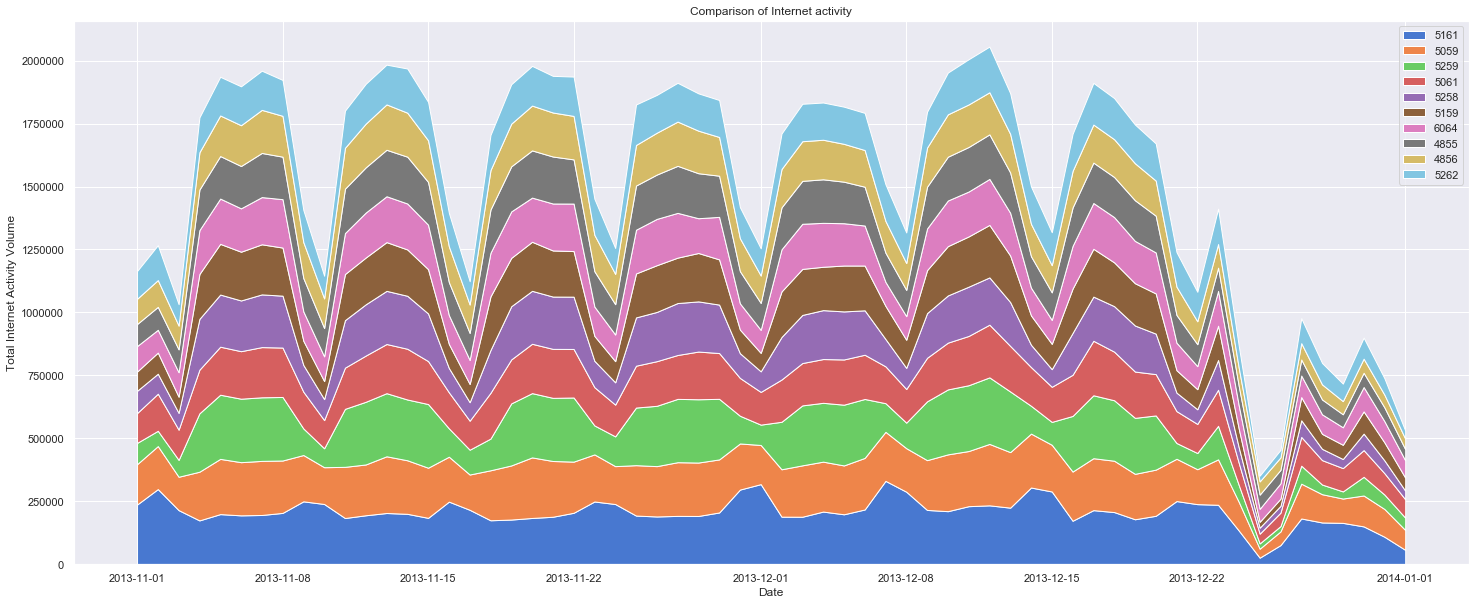

In [16]:
#Plot daily Internet activity for top 10 grids from Nov 1, 2013 to Jan 1, 2014
plt.figure(figsize=(25,10))
ax = plt.stackplot(daily5161.index, daily5161.internet,daily5059.internet,
                   daily5259.internet, daily5061.internet, daily5258.internet,
                   daily5159.internet, daily6064.internet, daily4855.internet,
                   daily4856.internet, daily5262.internet,
                   labels = top10['internet'],colors=col)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Internet Activity Volume')
plt.title('Comparison of Internet activity')
plt.show()

# Statistical Analysis of top 10 grids

First 4 grids have highly varying total volume and rest of the grids have almost same total volume for each activity. This is further verified by performing a set of one-way ANOVA tests.    
P-value < 0.05 indicates rejects the Null hypothesis that the mean values are equal.

In [17]:
#import scipy.stats to perform One-Way ANOVA teste
import scipy.stats as stats

In [18]:
#Comparison of mean SMS values of top 4 grids 
stats.f_oneway(daily5059.sms.to_list(), daily5161.sms.to_list(), daily6064.sms.to_list(), daily5061.sms.to_list())

F_onewayResult(statistic=15.6837152166561, pvalue=2.3305180034398526e-09)

In [19]:
#Comparison of mean SMS values of rest of the grids from the top 10 list
stats.f_oneway(daily5159.sms.to_list(), daily5259.sms.to_list(), daily5262.sms.to_list(), daily4855.sms.to_list(),
               daily4856.sms.to_list(), daily6165.sms.to_list())

F_onewayResult(statistic=1.0806731220881904, pvalue=0.37063204247098347)

In [20]:
#Comparison of mean Call values of top 4 grids 
stats.f_oneway(daily5059.call.to_list(), daily6064.call.to_list(), daily5161.call.to_list(), daily5159.call.to_list())

F_onewayResult(statistic=8.245022535234758, pvalue=3.0159552209709387e-05)

In [21]:
#Comparison of mean Call values of rest of the grids from the top 10 list
stats.f_oneway(daily5061.call.to_list(), daily5259.call.to_list(), daily6165.call.to_list(), daily5262.call.to_list(),
               daily6058.call.to_list(), daily5162.call.to_list())

F_onewayResult(statistic=2.089333950123052, pvalue=0.06609465518655394)

In [22]:
#Comparison of mean Internet values of top 4 grids 
stats.f_oneway(daily5161.internet.to_list(), daily5059.internet.to_list(), daily5259.internet.to_list(),
               daily5061.internet.to_list())

F_onewayResult(statistic=8.388137367527829, pvalue=2.5001501890290148e-05)

In [23]:
#Comparison of mean Internet values of rest of the grids from the top 10 list
stats.f_oneway(daily5258.internet.to_list(), daily5159.internet.to_list(), daily6064.internet.to_list(),
               daily4855.internet.to_list(), daily4856.internet.to_list(), daily5262.internet.to_list())

F_onewayResult(statistic=0.42971229199857125, pvalue=0.8278755021476163)

In order to capture variations in the city’s telecommunication activities, we will examine the following four grids that has markedly different behavioral signatures,   
4459 - Bocconi, one of the most famous Universities in Milan    
4456 - Navigli district, one of the most famous nightlife places in Milan    
5060 - Duomo, the city center of Milan    
5646 - Fiera, residential neighborhood of Milan   

#### Comparison of daily activity pattern

<Figure size 1800x720 with 0 Axes>

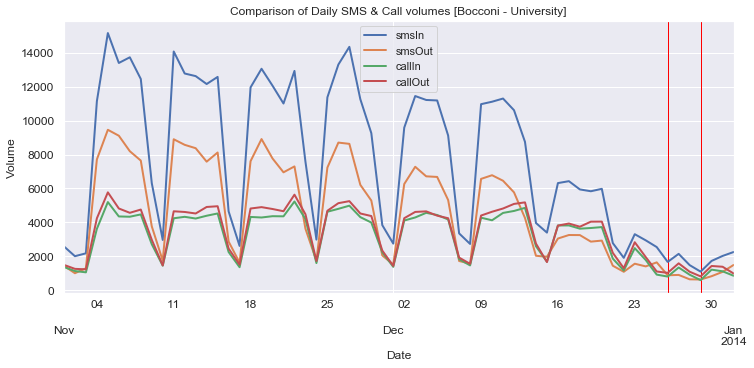

In [24]:
#Next line is to fix an error
pd.plotting.register_matplotlib_converters()

#Plot Daily SMS-In, SMS-Out, Call-In, Call-Out activity pattern for Bocconi - Univerisity
daily4459 = dailyGridActivity.loc[4459]
plt.figure(figsize=(25,10))
ax = daily4459.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(12, 5), fontsize=12, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of Daily SMS & Call volumes [Bocconi - University]')
plt.axvspan('2013-12-26', '2013-12-26', color='red')
plt.axvspan('2013-12-29', '2013-12-29', color='red')
plt.show()

<Figure size 1800x720 with 0 Axes>

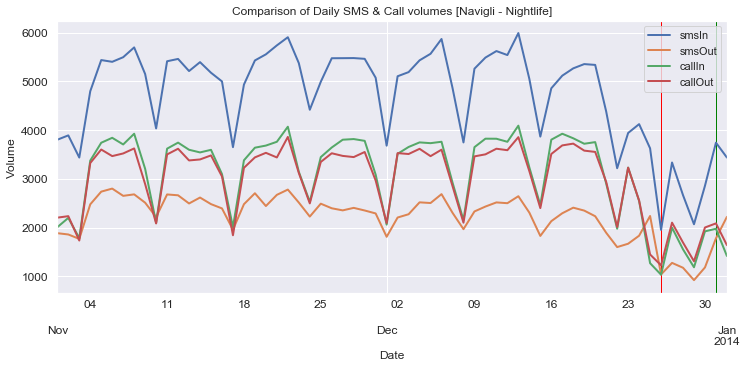

In [25]:
#Plot Daily SMS-In, SMS-Out, Call-In, Call-Out activity pattern for Navigli - Nightlife
daily4456 = dailyGridActivity.loc[4456]
plt.figure(figsize=(25,10))
ax = daily4456.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(12, 5), fontsize=12, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of Daily SMS & Call volumes [Navigli - Nightlife]')
plt.axvspan('2013-12-26', '2013-12-26', color='red')
plt.axvspan('2013-12-31', '2013-12-31', color='green')
plt.show()

<Figure size 1800x720 with 0 Axes>

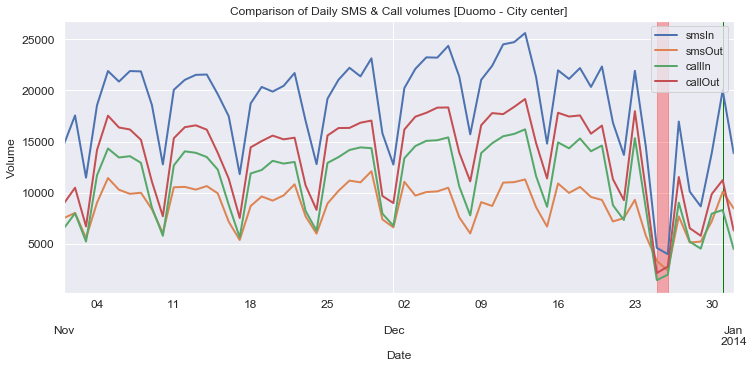

In [26]:
#Plot Daily SMS-In, SMS-Out, Call-In, Call-Out activity pattern for Duomo - City center
daily5059 = dailyGridActivity.loc[5059]
plt.figure(figsize=(25,10))
ax = daily5059.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(12, 5), fontsize=12, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of Daily SMS & Call volumes [Duomo - City center]')
plt.axvspan('2013-12-25', '2013-12-26', color='red', alpha=0.3)
plt.axvspan('2013-12-31', '2013-12-31', color='green')
plt.show()

<Figure size 1800x720 with 0 Axes>

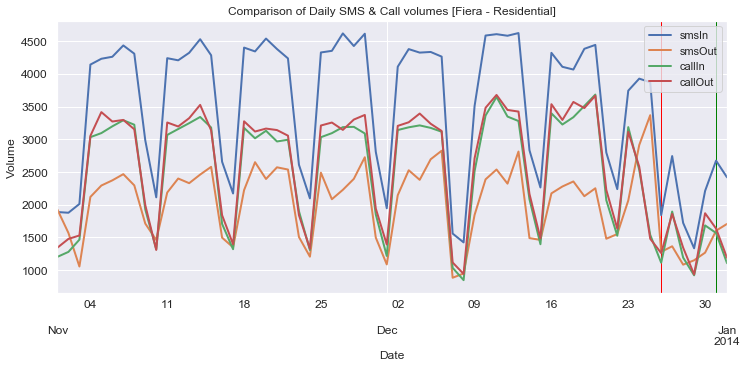

In [27]:
#Plot Daily SMS-In, SMS-Out, Call-In, Call-Out activity pattern for Fiera - Residential
daily5646 = dailyGridActivity.loc[5646]
plt.figure(figsize=(25,10))
ax = daily5646.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(12, 5), fontsize=12, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of Daily SMS & Call volumes [Fiera - Residential]')
plt.axvspan('2013-12-26', '2013-12-26', color='red')
plt.axvspan('2013-12-31', '2013-12-31', color='green')
plt.show()

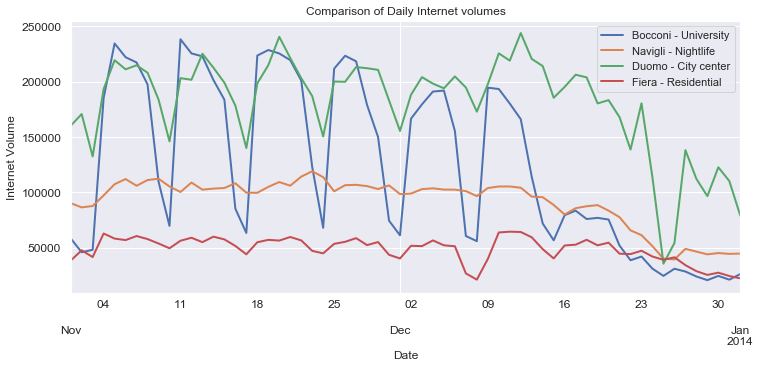

In [28]:
#Plot Daily Internet activity pattern for all four places
plt.figure(figsize=(25,10))
ax = daily4459['internet'].plot(figsize=(12, 5), fontsize=12, linewidth=2, label = 'Bocconi - University', legend='True')
ax = daily4456['internet'].plot(figsize=(12, 5), fontsize=12, linewidth=2, label = 'Navigli - Nightlife', legend='True')
ax = daily5059['internet'].plot(figsize=(12, 5), fontsize=12, linewidth=2, label = 'Duomo - City center', legend='True')
ax = daily5646['internet'].plot(figsize=(12, 5), fontsize=12, linewidth=2, label = 'Fiera - Residential', legend='True')
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.title('Comparison of Daily Internet volumes')
plt.show()

#### Comparison of hourly activity pattern

In [29]:
#Set this to None to avoid Warning messages from Pandas
pd.options.mode.chained_assignment = None

#Get hourly data for the four grids 
hourly4459 = hourlyGridActivity.loc[4459]
hourly4456 = hourlyGridActivity.loc[4456]
hourly5059 = hourlyGridActivity.loc[5059]
hourly5646 = hourlyGridActivity.loc[5646]

#Add column to identify Day of the week for each observation
hourly4459['dayOfWeek'] = hourly4459.index.day_name()
hourly4456['dayOfWeek'] = hourly4456.index.day_name()
hourly5059['dayOfWeek'] = hourly5059.index.day_name()
hourly5646['dayOfWeek'] = hourly5646.index.day_name()

#Use pivot_table() reshape the dataframe with Mean values of the acitivities for Day of the week as columns and hours in a day as index
hourly4459_sms = hourly4459.pivot_table(index=hourly4459.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly4459_call = hourly4459.pivot_table(index=hourly4459.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly4459_internet = hourly4459.pivot_table(index=hourly4459.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')
hourly4456_sms = hourly4456.pivot_table(index=hourly4456.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly4456_call = hourly4456.pivot_table(index=hourly4456.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly4456_internet = hourly4456.pivot_table(index=hourly4456.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')
hourly5059_sms = hourly5059.pivot_table(index=hourly5059.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly5059_call = hourly5059.pivot_table(index=hourly5059.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly5059_internet = hourly5059.pivot_table(index=hourly5059.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')
hourly5646_sms = hourly5646.pivot_table(index=hourly5646.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly5646_call = hourly5646.pivot_table(index=hourly5646.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly5646_internet = hourly5646.pivot_table(index=hourly5646.index.hour,
                                                    columns='dayOfWeek', values='internet', aggfunc='mean')

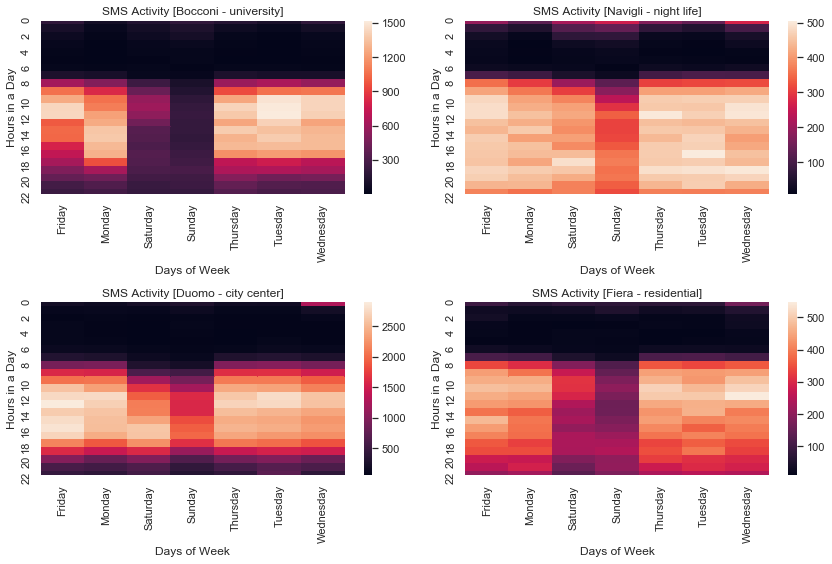

In [32]:
#From the reshaped dataframe plot heatmap for SMS activity of the four grids
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
ax[0][0].set_title("SMS Activity [Bocconi - university]")
ax[0][1].set_title("SMS Activity [Navigli - night life]")
ax[1][0].set_title("SMS Activity [Duomo - city center]")
ax[1][1].set_title("SMS Activity [Fiera - residential]")

sns.heatmap(hourly4459_sms, ax=ax[0][0])
ax[0][0].set_ylabel("Hours in a Day")
ax[0][0].set_xlabel("Days of Week")
sns.heatmap(hourly4456_sms, ax=ax[0][1])
ax[0][1].set_ylabel("Hours in a Day")
ax[0][1].set_xlabel("Days of Week")
sns.heatmap(hourly5059_sms, ax=ax[1][0])
ax[1][0].set_ylabel("Hours in a Day")
ax[1][0].set_xlabel("Days of Week")
sns.heatmap(hourly5646_sms, ax=ax[1][1])
ax[1][1].set_ylabel("Hours in a Day")
ax[1][1].set_xlabel("Days of Week")
fig. tight_layout()

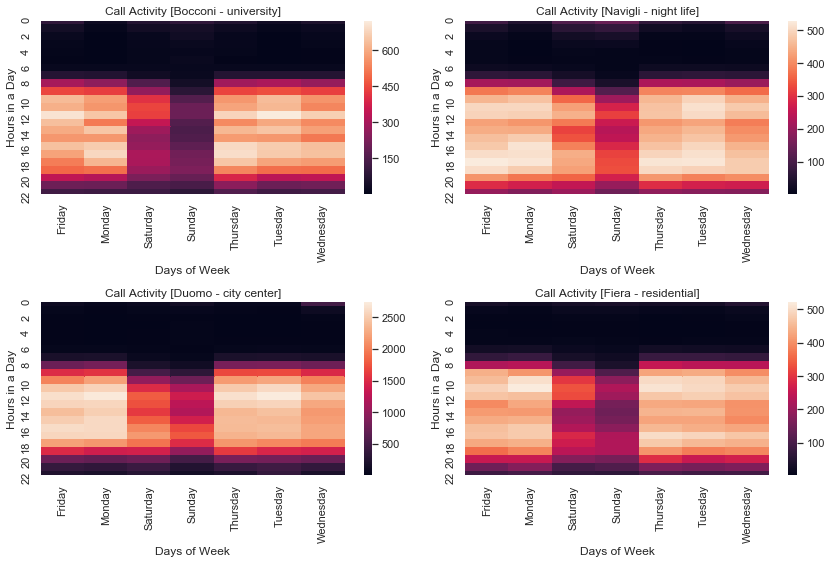

In [33]:
#From the reshaped dataframe plot heatmap for Call activity of the four grids
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
ax[0][0].set_title("Call Activity [Bocconi - university]")
ax[0][1].set_title("Call Activity [Navigli - night life]")
ax[1][0].set_title("Call Activity [Duomo - city center]")
ax[1][1].set_title("Call Activity [Fiera - residential]")

sns.heatmap(hourly4459_call, ax=ax[0][0])
ax[0][0].set_ylabel("Hours in a Day")
ax[0][0].set_xlabel("Days of Week")
sns.heatmap(hourly4456_call, ax=ax[0][1])
ax[0][1].set_ylabel("Hours in a Day")
ax[0][1].set_xlabel("Days of Week")
sns.heatmap(hourly5059_call, ax=ax[1][0])
ax[1][0].set_ylabel("Hours in a Day")
ax[1][0].set_xlabel("Days of Week")
sns.heatmap(hourly5646_call, ax=ax[1][1])
ax[1][1].set_ylabel("Hours in a Day")
ax[1][1].set_xlabel("Days of Week")
fig. tight_layout()

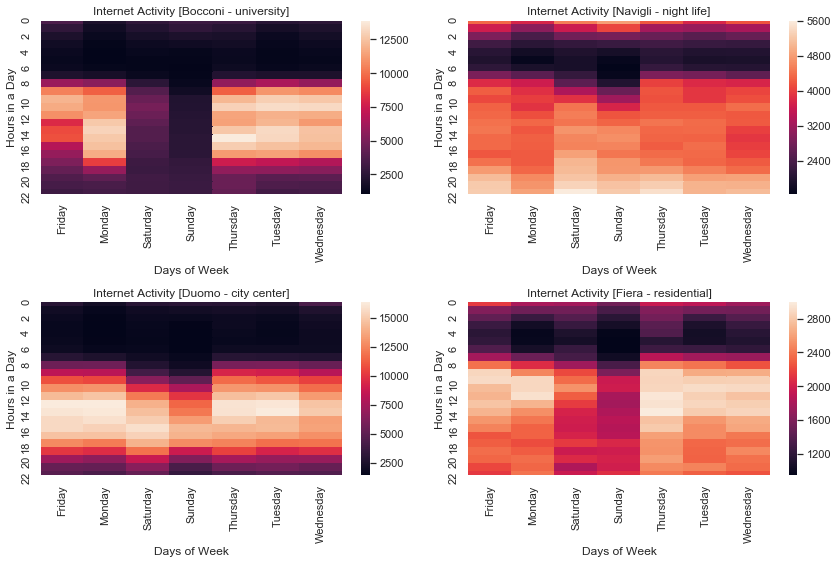

In [34]:
#From the reshaped dataframe plot heatmap for Internet activity of the four grids
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
ax[0][0].set_title("Internet Activity [Bocconi - university]")
ax[0][1].set_title("Internet Activity [Navigli - night life]")
ax[1][0].set_title("Internet Activity [Duomo - city center]")
ax[1][1].set_title("Internet Activity [Fiera - residential]")

sns.heatmap(hourly4459_internet, ax=ax[0][0])
ax[0][0].set_ylabel("Hours in a Day")
ax[0][0].set_xlabel("Days of Week")
sns.heatmap(hourly4456_internet, ax=ax[0][1])
ax[0][1].set_ylabel("Hours in a Day")
ax[0][1].set_xlabel("Days of Week")
sns.heatmap(hourly5059_internet, ax=ax[1][0])
ax[1][0].set_ylabel("Hours in a Day")
ax[1][0].set_xlabel("Days of Week")
sns.heatmap(hourly5646_internet, ax=ax[1][1])
ax[1][1].set_ylabel("Hours in a Day")
ax[1][1].set_xlabel("Days of Week")
fig. tight_layout()

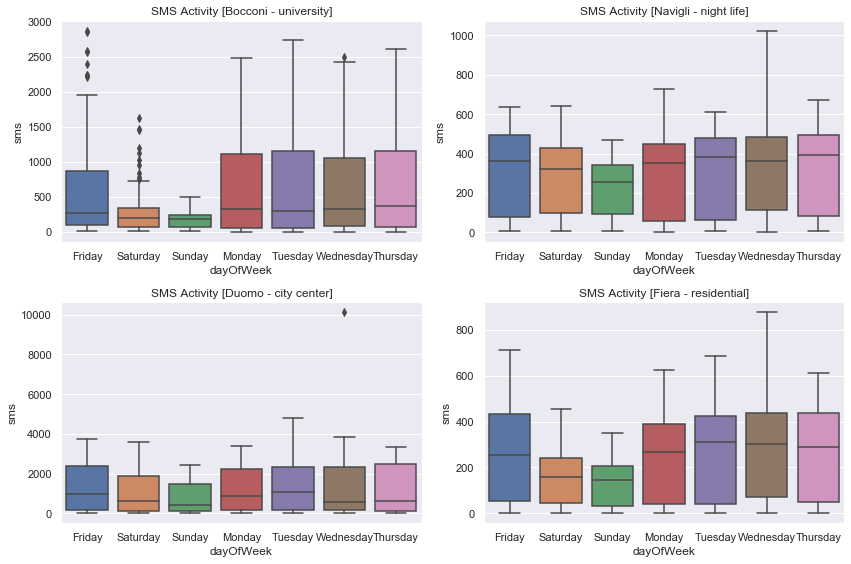

In [35]:
#Plot box plot of SMS activity for each day of the week
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
ax[0][0].set_title("SMS Activity [Bocconi - university]")
ax[0][1].set_title("SMS Activity [Navigli - night life]")
ax[1][0].set_title("SMS Activity [Duomo - city center]")
ax[1][1].set_title("SMS Activity [Fiera - residential]")

sns.boxplot(hourly4459['dayOfWeek'], hourly4459['sms'], ax=ax[0][0])
sns.boxplot(hourly4456['dayOfWeek'], hourly4456['sms'], ax=ax[0][1])
sns.boxplot(hourly5059['dayOfWeek'], hourly5059['sms'], ax=ax[1][0])
sns.boxplot(hourly5646['dayOfWeek'], hourly5646['sms'], ax=ax[1][1])
fig. tight_layout()

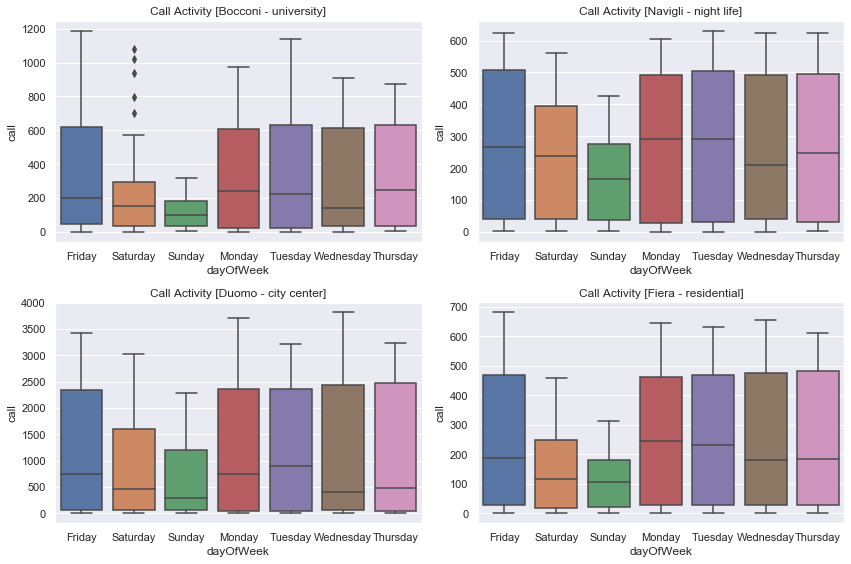

In [36]:
#Plot box plot of Call activity for each day of the week
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
ax[0][0].set_title("Call Activity [Bocconi - university]")
ax[0][1].set_title("Call Activity [Navigli - night life]")
ax[1][0].set_title("Call Activity [Duomo - city center]")
ax[1][1].set_title("Call Activity [Fiera - residential]")

sns.boxplot(hourly4459['dayOfWeek'], hourly4459['call'], ax=ax[0][0])
sns.boxplot(hourly4456['dayOfWeek'], hourly4456['call'], ax=ax[0][1])
sns.boxplot(hourly5059['dayOfWeek'], hourly5059['call'], ax=ax[1][0])
sns.boxplot(hourly5646['dayOfWeek'], hourly5646['call'], ax=ax[1][1])
fig. tight_layout()

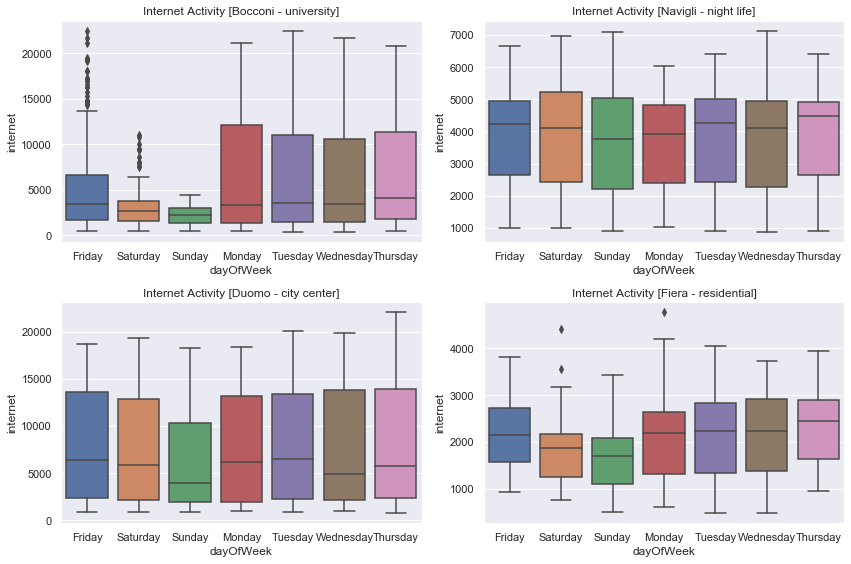

In [37]:
#Plot box plot of Internet activity for each day of the week
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
ax[0][0].set_title("Internet Activity [Bocconi - university]")
ax[0][1].set_title("Internet Activity [Navigli - night life]")
ax[1][0].set_title("Internet Activity [Duomo - city center]")
ax[1][1].set_title("Internet Activity [Fiera - residential]")

sns.boxplot(hourly4459['dayOfWeek'], hourly4459['internet'], ax=ax[0][0])
sns.boxplot(hourly4456['dayOfWeek'], hourly4456['internet'], ax=ax[0][1])
sns.boxplot(hourly5059['dayOfWeek'], hourly5059['internet'], ax=ax[1][0])
sns.boxplot(hourly5646['dayOfWeek'], hourly5646['internet'], ax=ax[1][1])
fig. tight_layout()

# Machine Learning 1 - CLUSTERING

## Feature Engineering

Feature Engineering is nothing but extracting more information from the existing time series data that helps Clustering algorithm to understand each grid better. We will create a total of 101 features that are indexed by grid id. 

In [40]:
#Create a separate dataframe for weekday and weekend activities
hourlyGridActivity_WE = hourlyGridActivity[hourlyGridActivity['weekdayFlag'].isin([5,6])]
hourlyGridActivity_WD = hourlyGridActivity[~hourlyGridActivity['weekdayFlag'].isin([5,6])]
dailyGridActivity_WE = dailyGridActivity[dailyGridActivity['weekdayFlag'].isin([5,6])]
dailyGridActivity_WD = dailyGridActivity[~dailyGridActivity['weekdayFlag'].isin([5,6])]

In [41]:
#Add hourly metrics - Max, Min & Avg activity volume for each grid in hourly data
gridActivity = pd.DataFrame()
df = pd.DataFrame()
df = hourlyGridActivity_WE.reset_index()

df1 = df.groupby(['gridID','hours'])[['sms']].mean()
df1.reset_index(level=1,drop=True,inplace=True)
hourlyMaxSms_WE = df1.groupby(['gridID'])[['sms']].max()
hourlyMaxSms_WE.columns = ['hourlysmsMax_WE']
hourlyMinSms_WE = df1.groupby(['gridID'])[['sms']].min()
hourlyMinSms_WE.columns = ['hourlysmsMin_WE']
hourlyAvgSms_WE = df1.groupby(['gridID'])[['sms']].mean()
hourlyAvgSms_WE.columns = ['hourlysmsAvg_WE']


df1 = df.groupby(['gridID','hours'])[['call']].mean()
df1.reset_index(level=1,drop=True,inplace=True)
hourlyMaxCall_WE = df1.groupby(['gridID'])[['call']].max()
hourlyMaxCall_WE.columns = ['hourlycallMax_WE']
hourlyMinCall_WE = df1.groupby(['gridID'])[['call']].min()
hourlyMinCall_WE.columns = ['hourlycallMin_WE']
hourlyAvgCall_WE = df1.groupby(['gridID'])[['call']].mean()
hourlyAvgCall_WE.columns = ['hourlycallAvg_WE']

df1 = df.groupby(['gridID','hours'])[['internet']].mean()
df1.reset_index(level=1,drop=True,inplace=True)
hourlyMaxInternet_WE = df1.groupby(['gridID'])[['internet']].max()
hourlyMaxInternet_WE.columns = ['hourlyinternetMax_WE']
hourlyMinInternet_WE = df1.groupby(['gridID'])[['internet']].min()
hourlyMinInternet_WE.columns = ['hourlyinternetMin_WE']
hourlyAvgInternet_WE = df1.groupby(['gridID'])[['internet']].mean()
hourlyAvgInternet_WE.columns = ['hourlyinternetAvg_WE']


df = hourlyGridActivity_WD.reset_index()

df1 = df.groupby(['gridID','hours'])[['sms']].mean()
df1.reset_index(level=1,drop=True,inplace=True)
hourlyMaxSms_WD = df1.groupby(['gridID'])[['sms']].max()
hourlyMaxSms_WD.columns = ['hourlysmsMax_WD']
hourlyMinSms_WD = df1.groupby(['gridID'])[['sms']].min()
hourlyMinSms_WD.columns = ['hourlysmsMin_WD']
hourlyAvgSms_WD = df1.groupby(['gridID'])[['sms']].mean()
hourlyAvgSms_WD.columns = ['hourlysmsAvg_WD']

df1 = df.groupby(['gridID','hours'])[['call']].mean()
df1.reset_index(level=1,drop=True,inplace=True)
hourlyMaxCall_WD = df1.groupby(['gridID'])[['call']].max()
hourlyMaxCall_WD.columns = ['hourlycallMax_WD']
hourlyMinCall_WD = df1.groupby(['gridID'])[['call']].min()
hourlyMinCall_WD.columns = ['hourlycallMin_WD']
hourlyAvgCall_WD = df1.groupby(['gridID'])[['call']].mean()
hourlyAvgCall_WD.columns = ['hourlycallAvg_WD']

df1 = df.groupby(['gridID','hours'])[['internet']].mean()
df1.reset_index(level=1,drop=True,inplace=True)
hourlyMaxInternet_WD = df1.groupby(['gridID'])[['internet']].max()
hourlyMaxInternet_WD.columns = ['hourlyinternetMax_WD']
hourlyMinInternet_WD = df1.groupby(['gridID'])[['internet']].min()
hourlyMinInternet_WD.columns = ['hourlyinternetMin_WD']
hourlyAvgInternet_WD = df1.groupby(['gridID'])[['internet']].mean()
hourlyAvgInternet_WD.columns = ['hourlyinternetAvg_WD']

#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,hourlyMaxSms_WE, hourlyMaxCall_WE, hourlyMaxInternet_WE,
                          hourlyMinSms_WE, hourlyMinCall_WE, hourlyMinInternet_WE,
                          hourlyAvgSms_WE, hourlyAvgCall_WE, hourlyAvgInternet_WE,
                          hourlyMaxSms_WD, hourlyMaxCall_WD,hourlyMaxInternet_WD,
                          hourlyMinSms_WD, hourlyMinCall_WD,hourlyMinInternet_WD,
                          hourlyAvgSms_WD, hourlyAvgCall_WD,hourlyAvgInternet_WD], axis=1)


In [42]:
#Add daytime hour volumes, weekday & weekend
mask = (hourlyGridActivity_WE.hours >= 8) & (hourlyGridActivity_WE.hours < 22)
dayGridActivity_WE = hourlyGridActivity_WE[mask]
dayGridActivity_WE = dayGridActivity_WE.groupby(['gridID'])[['sms','call','internet']].sum()
dayGridActivity_WE.columns = ['totalSmsDay_WE','totalCallDay_WE','totalInternetDay_WE']

mask = (hourlyGridActivity_WD.hours >= 8) & (hourlyGridActivity_WD.hours < 22)
dayGridActivity_WD = hourlyGridActivity_WD[mask]
dayGridActivity_WD = dayGridActivity_WD.groupby(['gridID'])[['sms','call','internet']].sum()
dayGridActivity_WD.columns = ['totalSmsDay_WD','totalCallDay_WD','totalInternetDay_WD']

#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,dayGridActivity_WE, dayGridActivity_WD], axis=1)

In [43]:
#Add night time volumes, weekday & weekend
mask = (hourlyGridActivity_WE.hours >= 0) & (hourlyGridActivity_WE.hours < 8)
nightGridActivity_WE = hourlyGridActivity_WE[mask]
nightGridActivity_WE = nightGridActivity_WE.groupby(['gridID'])[['sms','call','internet']].sum()
nightGridActivity_WE.columns = ['totalSmsNight_WE','totalCallNight_WE','totalInternetNight_WE']

mask = (hourlyGridActivity_WD.hours >= 0) & (hourlyGridActivity_WD.hours < 8)
nightGridActivity_WD = hourlyGridActivity_WD[mask]
nightGridActivity_WD = nightGridActivity_WD.groupby(['gridID'])[['sms','call','internet']].sum()
nightGridActivity_WD.columns = ['totalSmsNight_WD','totalCallNight_WD','totalInternetNight_WD']

#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,nightGridActivity_WE, nightGridActivity_WD], axis=1)

In [44]:
#Add Daily metrics SmsIN/SmsOut, CallIn/CallOut, SMS/Call, SMS+Call/Internet ratios
df = dailyGridActivity.reset_index()
df.drop(columns='startTime',inplace=True)
df = df.groupby(['gridID']).sum()
gridActivity['dailySmsIn/dailySmsOut'] = df['smsIn']/df['smsOut']
gridActivity['dailyCallIn/dailyCallOut'] = df['callIn']/df['callOut']
gridActivity['dailySms/dailyCall'] = (df['smsIn']+df['smsOut'])/(df['callIn']+df['callOut'])
gridActivity['dailyInternet/dailySmsCall'] = df['internet']/(df['smsIn']+df['smsOut']+df['callIn']+df['callOut'])


In [45]:
#Seperate weekend and weekday data from daily data to get max volumes for each category

weekDayMax = dailyGridActivity_WD.groupby(['gridID'])['sms', 'call', 'internet'].max()
weekDayMax.columns = ['smsMax_WD', 'callMax_WD','internetMax_WD']

weekDayMin = dailyGridActivity_WD.groupby(['gridID'])['sms', 'call', 'internet'].min()
weekDayMin.columns = ['smsMin_WD', 'callMin_WD','internetMin_WD']

weekDayAvg = dailyGridActivity_WD.groupby(['gridID'])['sms', 'call', 'internet'].mean()
weekDayAvg.columns = ['smsAvg_WD', 'callAvg_WD','internetAvg_WD']

weekEndMax = dailyGridActivity_WE.groupby(['gridID'])['sms', 'call', 'internet'].max()
weekEndMax.columns = ['smsMax_WE', 'callMax_WE','internetMax_WE']

weekEndMin = dailyGridActivity_WE.groupby(['gridID'])['sms', 'call', 'internet'].min()
weekEndMin.columns = ['smsMin_WE', 'callMin_WE','internetMin_WE']

weekEndAvg = dailyGridActivity_WE.groupby(['gridID'])['sms', 'call', 'internet'].mean()
weekEndAvg.columns = ['smsAvg_WE', 'callAvg_WE','internetAvg_WE']

#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity, weekEndMax, weekEndMin, weekDayMax, weekDayMin, weekEndAvg, 
                          weekDayAvg], axis=1)

In [46]:
#Add Weekly metrics
#weekly averages
weeklyAvgGridActivity= dailyGridActivity.reset_index(level='startTime')
weeklyAvgGridActivity = weeklyAvgGridActivity.groupby(['gridID', pd.Grouper(key='startTime',
                                                              freq='W')])['sms', 'call', 'internet'].mean()

#Week-to-Week Avg difference
#Calculate First discrete difference
weeklyChange = weeklyAvgGridActivity.diff().fillna(0)
weeklyChange.columns = ['smsAvgdiff_weekly','callAvgdiff_weekly','internetAvgdiff_weekly']

#Calculate the average of the differences
weeklyAvgChange = weeklyChange.groupby(['gridID']).mean()

#weekly Max & Min
weeklyGridActivity = dailyGridActivity.reset_index(level='startTime')
weeklyGridActivity = weeklyGridActivity.groupby(['gridID', pd.Grouper(key='startTime', freq='W')]).sum()

weeklyMaxGridActivity = weeklyGridActivity.groupby(['gridID'])['sms', 'call', 'internet'].max()
weeklyMaxGridActivity.columns = ['smsMax_weekly','callMax_weekly','internetMax_weekly' ]

weeklyMinGridActivity = weeklyGridActivity.groupby(['gridID'])['sms', 'call', 'internet'].min()
weeklyMinGridActivity.columns = ['smsMin_weekly','callMin_weekly','internetMin_weekly' ]

weeklyAvgGridActivity = weeklyGridActivity.groupby(['gridID'])['sms', 'call', 'internet'].mean()
weeklyAvgGridActivity.columns = ['smsAvg_weekly','callAvg_weekly','internetAvg_weekly' ]

#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity, weeklyAvgChange, 
                          weeklyMaxGridActivity, weeklyMinGridActivity, weeklyAvgGridActivity], axis=1)

In [47]:
#monthly averages
monthlyGridActivity = dailyGridActivity.reset_index(level='startTime')

monthlyGridActivity_sum = monthlyGridActivity.groupby(['gridID', pd.Grouper(key='startTime', freq='M')]).sum()
monthlyAvgGridActivity = monthlyGridActivity_sum.groupby(['gridID'])['sms', 'call', 'internet'].mean()
monthlyAvgGridActivity.columns = ['monthlyAvg_sms','monthlyAvg_call','monthlyAvg_internet' ]

monthlyGridActivity_mean = monthlyGridActivity.groupby(['gridID', pd.Grouper(key='startTime', freq='M')]).mean()
monthlyAvgGridActivity_Nov = monthlyGridActivity_mean.loc[(slice(None), '2013-11-30'), ['sms', 'call', 'internet']]
monthlyAvgGridActivity_Nov.reset_index(level='startTime', drop=True, inplace=True)
monthlyAvgGridActivity_Nov.columns = ['smsAvg_Nov', 'callAvg_Nov', 'internetAvg_Nov']

monthlyAvgGridActivity_Dec = monthlyGridActivity_mean.loc[(slice(None), '2013-12-31'), ['sms', 'call', 'internet']]
monthlyAvgGridActivity_Dec.reset_index(level='startTime', drop=True, inplace=True)
monthlyAvgGridActivity_Dec.columns = ['smsAvg_Dec', 'callAvg_Dec', 'internetAvg_Dec']

monthlyGridActivity_max = monthlyGridActivity.groupby(['gridID', pd.Grouper(key='startTime', freq='M')]).max()
monthlyMaxGridActivity_Nov = monthlyGridActivity_max.loc[(slice(None), '2013-11-30'), ['sms', 'call', 'internet']]
monthlyMaxGridActivity_Nov.reset_index(level='startTime', drop=True, inplace=True)
monthlyMaxGridActivity_Nov.columns = ['smsMax_Nov', 'callMax_Nov', 'internetMax_Nov']

monthlyMaxGridActivity_Dec = monthlyGridActivity_max.loc[(slice(None), '2013-12-31'), ['sms', 'call', 'internet']]
monthlyMaxGridActivity_Dec.reset_index(level='startTime', drop=True, inplace=True)
monthlyMaxGridActivity_Dec.columns = ['smsMax_Dec', 'callMax_Dec', 'internetMax_Dec']

monthlyGridActivity_min = monthlyGridActivity.groupby(['gridID', pd.Grouper(key='startTime', freq='M')]).min()
monthlyMinGridActivity_Nov = monthlyGridActivity_min.loc[(slice(None), '2013-11-30'), ['sms', 'call', 'internet']]
monthlyMinGridActivity_Nov.reset_index(level='startTime', drop=True, inplace=True)
monthlyMinGridActivity_Nov.columns = ['smsMin_Nov', 'callMin_Nov', 'internetMin_Nov']

monthlyMinGridActivity_Dec = monthlyGridActivity_min.loc[(slice(None), '2013-12-31'), ['sms', 'call', 'internet']]
monthlyMinGridActivity_Dec.reset_index(level='startTime', drop=True, inplace=True)
monthlyMinGridActivity_Dec.columns = ['smsMin_Dec', 'callMin_Dec', 'internetMin_Dec']


#Concatenate the monthly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,monthlyAvgGridActivity, monthlyAvgGridActivity_Nov, 
                           monthlyAvgGridActivity_Dec, monthlyMaxGridActivity_Nov, monthlyMaxGridActivity_Dec, 
                           monthlyMinGridActivity_Nov, monthlyMinGridActivity_Dec], axis=1)


In [48]:
#Total volume on Christmas day
xMasGridActivity = dailyGridActivity.loc[(slice(None), '2013-12-25'), ['sms', 'call', 'internet']]
xMasGridActivity.columns = ['totalSms_xMas','totalCall_xMas','totalInternet_xMas']

xMasGridActivity.reset_index(level='startTime',inplace=True)
xMasGridActivity.drop(columns=['startTime'], inplace=True)
#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,xMasGridActivity], axis=1)

In [49]:
#Total volume on New Year day
newYearGridActivity = dailyGridActivity.loc[(slice(None), '2014-01-01'), ['sms', 'call', 'internet']]
newYearGridActivity.columns = ['totalSms_NewYear','totalCall_NewYear','totalInternet_NewYear']
newYearGridActivity.reset_index(level='startTime',inplace=True)
newYearGridActivity.drop(columns=['startTime'], inplace=True)
#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,newYearGridActivity], axis=1)

In [50]:
#Total volume on New Year Eve
newYearEveGridActivity = hourlyGridActivity.loc[(slice(None), slice('2013-12-31 18:00:00','2014-01-01 01:00:00')), ['sms', 'call', 'internet']]
newYearEveGridActivity = newYearEveGridActivity.groupby(['gridID']).sum()
newYearEveGridActivity.columns = ['totalSms_NewYearEve','totalCall_NewYearEve','totalInternet_NewYearEve']
#Concatenate the weekly average columns to gridActivity dataframe
gridActivity = pd.concat([gridActivity,newYearEveGridActivity], axis=1)

In [51]:
#Grid totals for all data
gridActivity[['totalSmsIn','totalSmsOut','totalSMS', 'totalCallIn','totalCallOut','totalCall', 
              'totalInternet']] = totalGridActivity[['smsIn', 'smsOut','sms', 'callIn', 'callOut', 'call', 'internet']]


In [52]:
#List all the features created
gridActivity.columns.values

array(['hourlysmsMax_WE', 'hourlycallMax_WE', 'hourlyinternetMax_WE',
       'hourlysmsMin_WE', 'hourlycallMin_WE', 'hourlyinternetMin_WE',
       'hourlysmsAvg_WE', 'hourlycallAvg_WE', 'hourlyinternetAvg_WE',
       'hourlysmsMax_WD', 'hourlycallMax_WD', 'hourlyinternetMax_WD',
       'hourlysmsMin_WD', 'hourlycallMin_WD', 'hourlyinternetMin_WD',
       'hourlysmsAvg_WD', 'hourlycallAvg_WD', 'hourlyinternetAvg_WD',
       'totalSmsDay_WE', 'totalCallDay_WE', 'totalInternetDay_WE',
       'totalSmsDay_WD', 'totalCallDay_WD', 'totalInternetDay_WD',
       'totalSmsNight_WE', 'totalCallNight_WE', 'totalInternetNight_WE',
       'totalSmsNight_WD', 'totalCallNight_WD', 'totalInternetNight_WD',
       'dailySmsIn/dailySmsOut', 'dailyCallIn/dailyCallOut',
       'dailySms/dailyCall', 'dailyInternet/dailySmsCall', 'smsMax_WE',
       'callMax_WE', 'internetMax_WE', 'smsMin_WE', 'callMin_WE',
       'internetMin_WE', 'smsMax_WD', 'callMax_WD', 'internetMax_WD',
       'smsMin_WD', 'callMin_WD

In [53]:
#Check for NAN values using assert statement, will throw an error if there are NaN values
assert gridActivity.notna().all().all()

AssertionError: 

In [54]:
#Display rows with NaN values
gridActivity[gridActivity.isna().any(axis=1)]

,hourlysmsMax_WE,hourlycallMax_WE,hourlyinternetMax_WE,hourlysmsMin_WE,hourlycallMin_WE,hourlyinternetMin_WE,hourlysmsAvg_WE,hourlycallAvg_WE,hourlyinternetAvg_WE,hourlysmsMax_WD,...,totalSms_NewYearEve,totalCall_NewYearEve,totalInternet_NewYearEve,totalSmsIn,totalSmsOut,totalSMS,totalCallIn,totalCallOut,totalCall,totalInternet
gridID,,,,,,,,,,,,,,,,,,,,,
5239,0.0,36.432346,0.654528,0.0,0.424817,0.000000,0.0,17.700773,0.238821,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,13933.276506,13933.276506,213.626535
5339,0.0,35.452106,1.909237,0.0,0.360011,0.600046,0.0,16.736923,1.032175,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,14558.416308,14558.416308,691.206812


In [55]:
#Fill NaN . values with 0 and assert again
gridActivity.fillna(0,inplace=True)
assert gridActivity.notna().all().all()

In [56]:
gridActivity.head()

,hourlysmsMax_WE,hourlycallMax_WE,hourlyinternetMax_WE,hourlysmsMin_WE,hourlycallMin_WE,hourlyinternetMin_WE,hourlysmsAvg_WE,hourlycallAvg_WE,hourlyinternetAvg_WE,hourlysmsMax_WD,...,totalSms_NewYearEve,totalCall_NewYearEve,totalInternet_NewYearEve,totalSmsIn,totalSmsOut,totalSMS,totalCallIn,totalCallOut,totalCall,totalInternet
gridID,,,,,,,,,,,,,,,,,,,,,
1,9.094208,9.548023,90.416289,0.328205,0.097580,34.951131,5.738641,4.092360,67.348068,10.740063,...,169.765438,49.937465,605.557763,6178.894730,3358.842325,9537.737054,3805.892719,3991.422048,7797.314767,92992.666580
2,9.215911,9.693760,90.829621,0.329970,0.099304,35.077204,5.817941,4.154366,67.614711,10.889624,...,172.031436,50.648657,607.574684,6267.021008,3402.658923,9669.679931,3861.301592,4052.842143,7914.143735,93368.388389
3,9.345460,9.848890,91.269597,0.331848,0.101140,35.211403,5.902353,4.220370,67.898541,11.048826,...,174.443501,51.405693,609.721617,6360.827944,3449.299959,9810.127903,3920.282146,4118.221405,8038.503551,93768.329391
4,8.741691,9.125896,89.219064,0.323096,0.092584,34.585960,5.508947,3.912755,66.575734,10.306857,...,163.201936,47.877483,599.715714,5923.635378,3231.926757,9155.562135,3645.399918,3813.517635,7458.917553,91904.381588
5,8.165829,8.512060,81.074814,0.304214,0.085393,31.540074,5.132871,3.648729,60.506417,9.612414,...,151.728535,44.758909,549.420748,5522.707656,3017.566898,8540.274554,3401.745307,3568.366951,6970.112258,83630.697355


In [57]:
#Convert drid wise dataframe with 101 features to Numpy, which is used by KMeans model in sklearn
x_cols = gridActivity.to_numpy()

## Finding the Optimal K value
### Elbow Method

In [58]:
from sklearn.cluster import KMeans
SS = []
for i in range(2,20):
    model = KMeans(n_clusters=i,random_state=40)
    model.fit(x_cols)
    #Attribute inertia_ gives sum of squared distances of samples to their closest cluster center
    SS.append(model.inertia_)

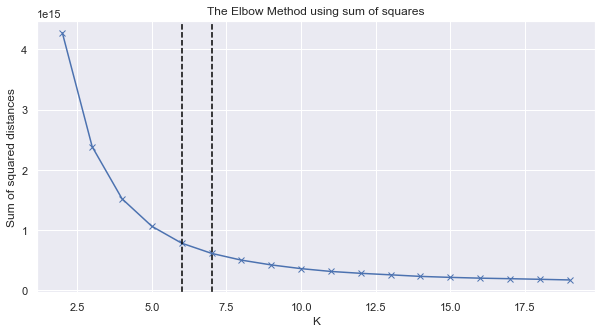

In [59]:
K = [i for i in range(2,20)]
plt.figure(figsize=(10,5))
plt.plot(K, SS, 'bx-') 
plt.axvline(6, color='black', ls='dashed')
plt.axvline(7, color='black', ls='dashed')
plt.xlabel('K') 
plt.ylabel('Sum of squared distances') 
plt.title('The Elbow Method using sum of squares')
plt.show()

From the Elbow Method, notice that we have a very smooth elbow. Curve plateaus after K=6 or K=7 

### Kneed Package

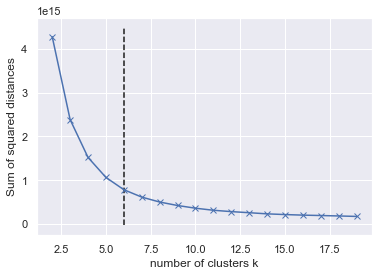

In [60]:
#Use Kneed package to verify the K value choosen
y = SS
x = [i for i in range(2,20)]

from kneed import KneeLocator
kn = KneeLocator(x, y, curve='convex', direction='decreasing')

import matplotlib.pyplot as plt
plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

### Silhouette coefficient plot

For n_clusters = 6 The average silhouette_score is : 0.6046354960998044


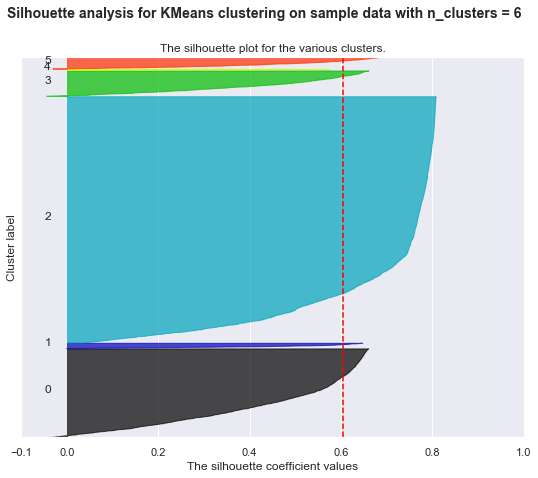

For n_clusters = 7 The average silhouette_score is : 0.5823526576081572


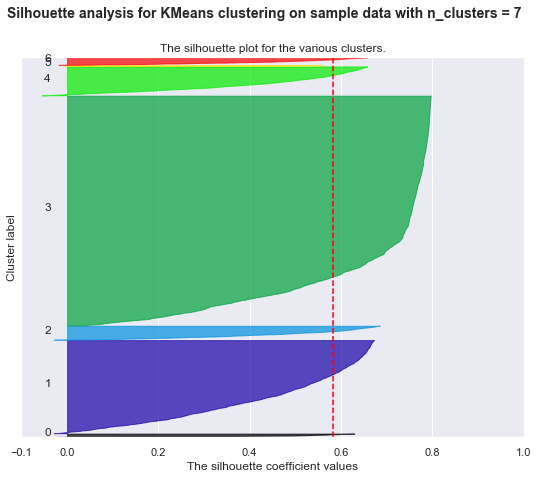

In [61]:
#Using Silhouette coefficient on various values of K
#Code is sourced from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = range(6,8)
avg_silhouette_score=[]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    #avg_silhouette_score will be used in next cell to plot against K
    avg_silhouette_score.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

From the Kneed Package and Silhouette coefficient plot we can conclude that the optimal K value is 6

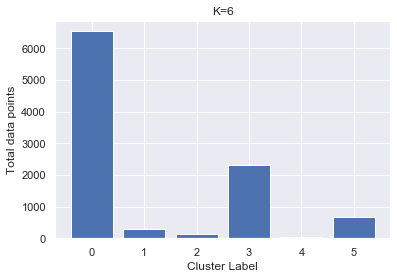

In [62]:
#Fit the model with K=6 and display the distribution of grids in each subgroup
model = KMeans(n_clusters=6,random_state=40)
model.fit(x_cols)
labels = model.labels_
unique, counts = np.unique(labels, return_counts=True)
plt.bar(range(0,6), counts)
plt.xlabel('Cluster Label') 
plt.ylabel('Total data points') 
plt.title('K=6') 
plt.show()

Text(0.5, 1.0, 'K-mean Clusters K=6')

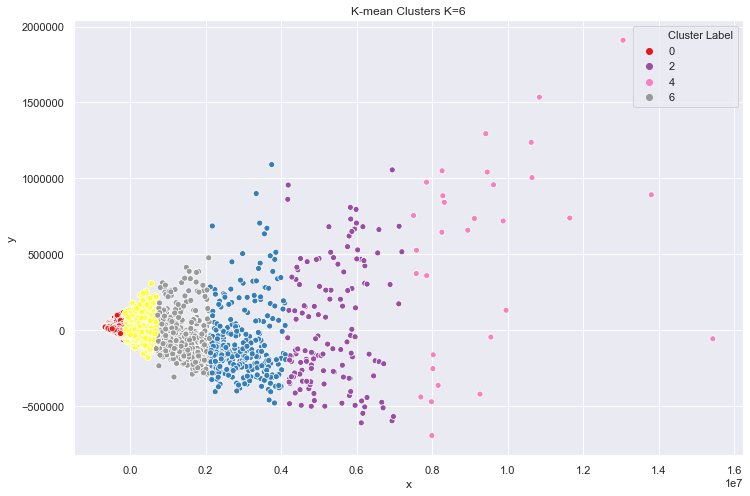

In [63]:
#KMean cluster with K=6 and display it using Principal component analysis. 
#PCA uses all the 92 dimensions and comes up with 2 dimensions X & Y. 

pd.set_option('mode.chained_assignment', None)
model = KMeans(n_clusters=6,random_state=40)
model.fit(x_cols)
labels = model.labels_

#Use scikit-learn's [`PCA`] function to reduce the dimensionality of your clustering data to 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_cols_pca = pca.fit_transform(x_cols)

np_grids = gridActivity.index.values
df = pd.DataFrame(np_grids)
df.columns = ['gridID']
df['Cluster Label'] = labels
df['x'] = x_cols_pca[: , 0]
df['y'] = x_cols_pca[: , 1]

#Plot a scatterplot of the `x` vs `y` columns
#Color-code points differently based on cluster ID
plt.figure(figsize=(12,8))
sns.scatterplot(x='x', y='y', data=df, hue='Cluster Label', palette='Set1').set_title('K-mean Clusters K=6')

In [64]:
#Number of grids in each cluster
ClusterResult = df.groupby('Cluster Label')['Cluster Label'].count()
ClusterResult = ClusterResult.to_frame()
ClusterResult.columns = ['Number of Grids']
ClusterResult

,Number of Grids
Cluster Label,
0,6541
1,300
2,139
3,2324
4,31
5,665


In [65]:
#Get the gridID from each cluster for display
cluster0Grid = df[df['Cluster Label']==0].gridID.tolist()
cluster1Grid = df[df['Cluster Label']==1].gridID.tolist()
cluster2Grid = df[df['Cluster Label']==2].gridID.tolist()
cluster3Grid = df[df['Cluster Label']==3].gridID.tolist()
cluster4Grid = df[df['Cluster Label']==4].gridID.tolist()
cluster5Grid = df[df['Cluster Label']==5].gridID.tolist()

In [ ]:
# Display the clustered grids in geojson file. 
# Cluster with more than 1895 grids does not get displayed through the display(). 
# Save this to a file and open in the browser.
milan = geopandas.read_file('Data/milano-grid.geojson')

displayGrid0 = milan.loc[milan['cellId'].isin(cluster0Grid)]
displayGrid0['fill'] = "#6ACC64"
displayGrid0['stroke-width'] = 0
displayGrid0['fill-opacity'] = 0.5
displayGrid0= displayGrid0.to_json()
file1 = open("grid0json.geojson","w") 
file1.write(displayGrid0)
file1.close()

displayGrid1 = milan.loc[milan['cellId'].isin(cluster1Grid)]
displayGrid1['fill'] = "#EE854A"
displayGrid1['stroke-width'] = 0
displayGrid1['fill-opacity'] = 0.7

displayGrid2 = milan.loc[milan['cellId'].isin(cluster2Grid)]
displayGrid2['fill'] = "#8C613C"
displayGrid2['stroke-width'] = 0
displayGrid2['fill-opacity'] = 0.7

displayGrid3 = milan.loc[milan['cellId'].isin(cluster3Grid)]
displayGrid3['fill'] = "#FFFF33"
displayGrid3['stroke-width'] = 0
displayGrid3['fill-opacity'] = 0.5
displayGrid3= displayGrid3.to_json()
file1 = open("grid3json.geojson","w") 
file1.write(displayGrid3)
file1.close()

displayGrid4 = milan.loc[milan['cellId'].isin(cluster4Grid)]
displayGrid4['fill'] = "#D65F5F"
displayGrid4['stroke-width'] = 0
displayGrid4['fill-opacity'] = 0.7

displayGrid5 = milan.loc[milan['cellId'].isin(cluster5Grid)]
displayGrid5['fill'] = "#D5BB67"
displayGrid5['stroke-width'] = 0
displayGrid5['fill-opacity'] = 0.7

displayGrid = pd.concat([displayGrid1,  displayGrid2, displayGrid4, displayGrid5], ignore_index=True)
displayGrid = displayGrid.to_json()
_ = geojsonio.display(displayGrid)


![title](images/clusters_geojson.png)

# Analysis of the Clusters
Plot subgroups against various dimensions in order to analyse different behavioral patterns

In [66]:
#Get the grid ids from each clusters
Cluster_0 = df[df["Cluster Label"] == 0].drop(columns=['x','y','Cluster Label'])
Cluster_1 = df[df["Cluster Label"] == 1].drop(columns=['x','y','Cluster Label'])
Cluster_2 = df[df["Cluster Label"] == 2].drop(columns=['x','y','Cluster Label'])
Cluster_3 = df[df["Cluster Label"] == 3].drop(columns=['x','y','Cluster Label'])
Cluster_4 = df[df["Cluster Label"] == 4].drop(columns=['x','y','Cluster Label'])
Cluster_5 = df[df["Cluster Label"] == 5].drop(columns=['x','y','Cluster Label'])

Cluster_0.reset_index(drop=True,inplace=True)
Cluster_1.reset_index(drop=True,inplace=True)
Cluster_2.reset_index(drop=True,inplace=True)
Cluster_3.reset_index(drop=True,inplace=True)
Cluster_4.reset_index(drop=True,inplace=True)
Cluster_5.reset_index(drop=True,inplace=True)

#Merge with the feature engineered dataframe, to get all the grids in each label along with all column values
Cluster0 = gridActivity[gridActivity.index.isin(Cluster_0.gridID)]
Cluster1 = gridActivity[gridActivity.index.isin(Cluster_1.gridID)]
Cluster2 = gridActivity[gridActivity.index.isin(Cluster_2.gridID)]
Cluster3 = gridActivity[gridActivity.index.isin(Cluster_3.gridID)]
Cluster4 = gridActivity[gridActivity.index.isin(Cluster_4.gridID)]
Cluster5 = gridActivity[gridActivity.index.isin(Cluster_5.gridID)]

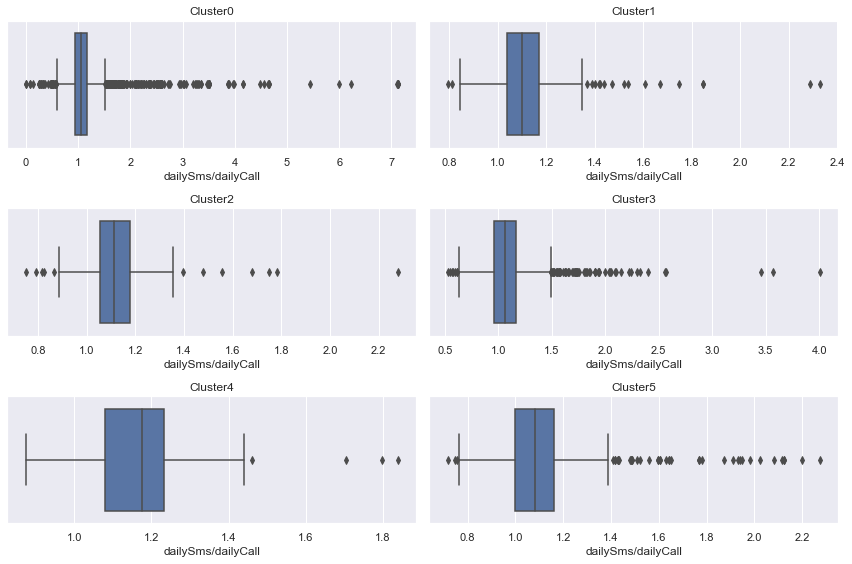

In [67]:
#Plot box plot of 6 subgroups dailySms/dailyCall
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['dailySms/dailyCall'], ax=ax[0][0])
sns.boxplot(x =Cluster1['dailySms/dailyCall'], ax=ax[0][1])
sns.boxplot(x =Cluster2['dailySms/dailyCall'], ax=ax[1][0])
sns.boxplot(x =Cluster3['dailySms/dailyCall'], ax=ax[1][1])
sns.boxplot(x =Cluster4['dailySms/dailyCall'], ax=ax[2][0])
sns.boxplot(x =Cluster5['dailySms/dailyCall'], ax=ax[2][1])
fig. tight_layout()

In [68]:
#One-way ANOVA test shows mean of dailySms/dailyCall is different for all the groups
group0 = Cluster0['dailySms/dailyCall'].to_list()
group1 = Cluster1['dailySms/dailyCall'].to_list()
group2 = Cluster2['dailySms/dailyCall'].to_list()
group3 = Cluster3['dailySms/dailyCall'].to_list()
group4 = Cluster4['dailySms/dailyCall'].to_list()
group5 = Cluster5['dailySms/dailyCall'].to_list()
stats.f_oneway(group0, group1, group2, group3, group4, group5)

F_onewayResult(statistic=2.90980079630057, pvalue=0.012516645020791636)

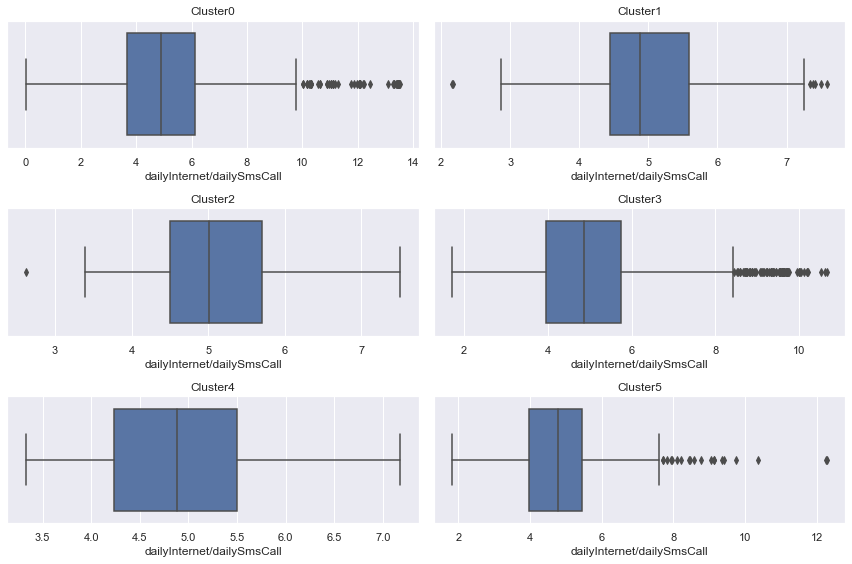

In [69]:
#Plot box plot of 6 subgroups dailyInternet/dailySmsCall
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['dailyInternet/dailySmsCall'], ax=ax[0][0])
sns.boxplot(x =Cluster1['dailyInternet/dailySmsCall'], ax=ax[0][1])
sns.boxplot(x =Cluster2['dailyInternet/dailySmsCall'], ax=ax[1][0])
sns.boxplot(x =Cluster3['dailyInternet/dailySmsCall'], ax=ax[1][1])
sns.boxplot(x =Cluster4['dailyInternet/dailySmsCall'], ax=ax[2][0])
sns.boxplot(x =Cluster5['dailyInternet/dailySmsCall'], ax=ax[2][1])
fig. tight_layout()

In [70]:
#One-way ANOVA test shows mean of dailyInternet/dailySmsCall is same for all the groups
group0 = Cluster0['dailyInternet/dailySmsCall'].to_list()
group1 = Cluster1['dailyInternet/dailySmsCall'].to_list()
group2 = Cluster2['dailyInternet/dailySmsCall'].to_list()
group3 = Cluster3['dailyInternet/dailySmsCall'].to_list()
group4 = Cluster4['dailyInternet/dailySmsCall'].to_list()
group5 = Cluster5['dailyInternet/dailySmsCall'].to_list()
stats.f_oneway(group0,group1,group2, group3, group4, group5)

F_onewayResult(statistic=1.5325777809082444, pvalue=0.17592855661097262)

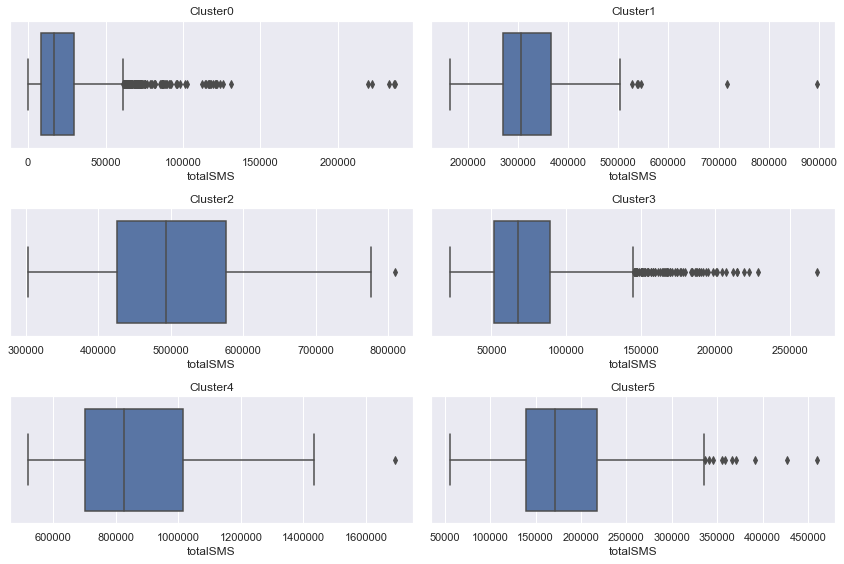

In [71]:
#Plot box plot of 6 subgroups totalSMS
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['totalSMS'], ax=ax[0][0])
sns.boxplot(x =Cluster1['totalSMS'], ax=ax[0][1])
sns.boxplot(x =Cluster2['totalSMS'], ax=ax[1][0])
sns.boxplot(x =Cluster3['totalSMS'], ax=ax[1][1])
sns.boxplot(x =Cluster4['totalSMS'], ax=ax[2][0])
sns.boxplot(x =Cluster5['totalSMS'], ax=ax[2][1])
fig. tight_layout()

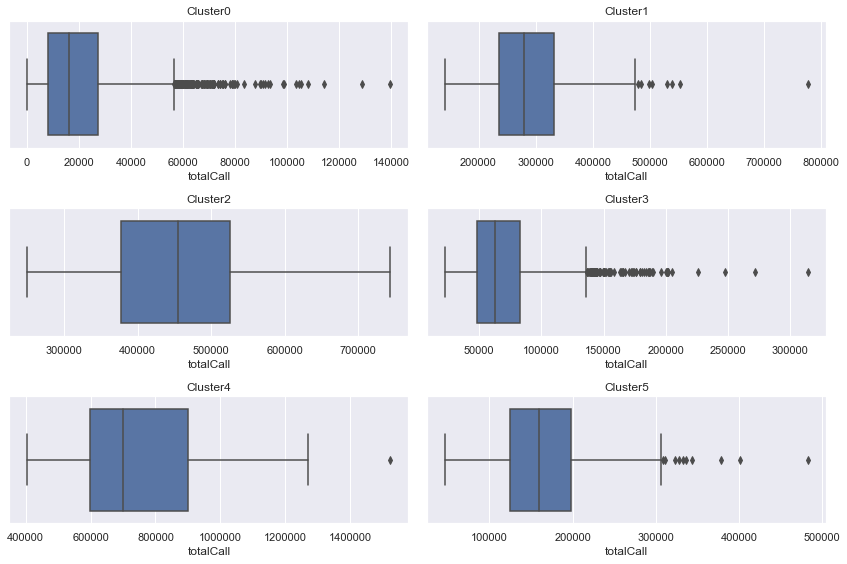

In [72]:
#Plot box plot of 6 subgroups totalCall
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['totalCall'], ax=ax[0][0])
sns.boxplot(x =Cluster1['totalCall'], ax=ax[0][1])
sns.boxplot(x =Cluster2['totalCall'], ax=ax[1][0])
sns.boxplot(x =Cluster3['totalCall'], ax=ax[1][1])
sns.boxplot(x =Cluster4['totalCall'], ax=ax[2][0])
sns.boxplot(x =Cluster5['totalCall'], ax=ax[2][1])
fig. tight_layout()

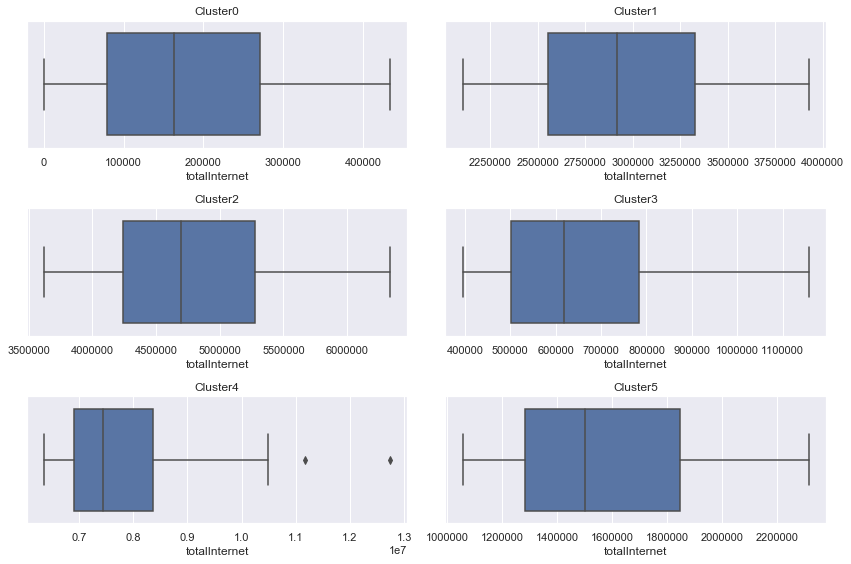

In [73]:
#Plot box plot of 6 subgroups totalInternet
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['totalInternet'], ax=ax[0][0])
sns.boxplot(x =Cluster1['totalInternet'], ax=ax[0][1])
sns.boxplot(x =Cluster2['totalInternet'], ax=ax[1][0])
sns.boxplot(x =Cluster3['totalInternet'], ax=ax[1][1])
sns.boxplot(x =Cluster4['totalInternet'], ax=ax[2][0])
sns.boxplot(x =Cluster5['totalInternet'], ax=ax[2][1])
fig. tight_layout()

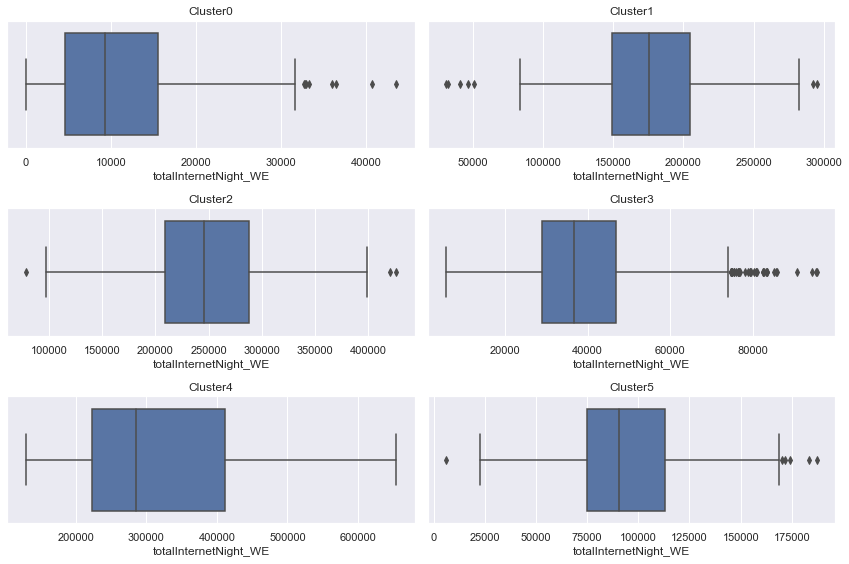

In [74]:
#Plot box plot of 6 subgroups totalInternetNight_WE
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['totalInternetNight_WE'], ax=ax[0][0])
sns.boxplot(x =Cluster1['totalInternetNight_WE'], ax=ax[0][1])
sns.boxplot(x =Cluster2['totalInternetNight_WE'], ax=ax[1][0])
sns.boxplot(x =Cluster3['totalInternetNight_WE'], ax=ax[1][1])
sns.boxplot(x =Cluster4['totalInternetNight_WE'], ax=ax[2][0])
sns.boxplot(x =Cluster5['totalInternetNight_WE'], ax=ax[2][1])
fig. tight_layout()

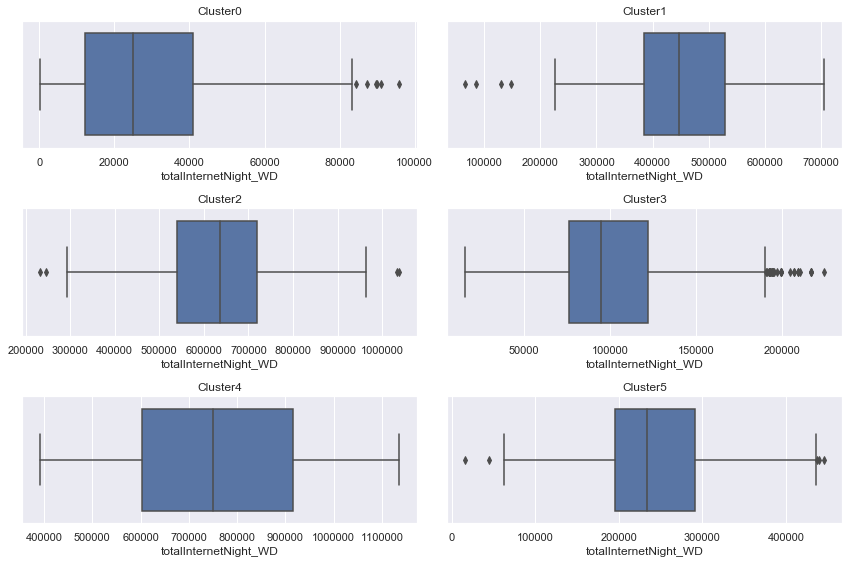

In [75]:
#Plot box plot of 6 subgroups totalInternetNight_WD
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['totalInternetNight_WD'], ax=ax[0][0])
sns.boxplot(x =Cluster1['totalInternetNight_WD'], ax=ax[0][1])
sns.boxplot(x =Cluster2['totalInternetNight_WD'], ax=ax[1][0])
sns.boxplot(x =Cluster3['totalInternetNight_WD'], ax=ax[1][1])
sns.boxplot(x =Cluster4['totalInternetNight_WD'], ax=ax[2][0])
sns.boxplot(x =Cluster5['totalInternetNight_WD'], ax=ax[2][1])
fig. tight_layout()

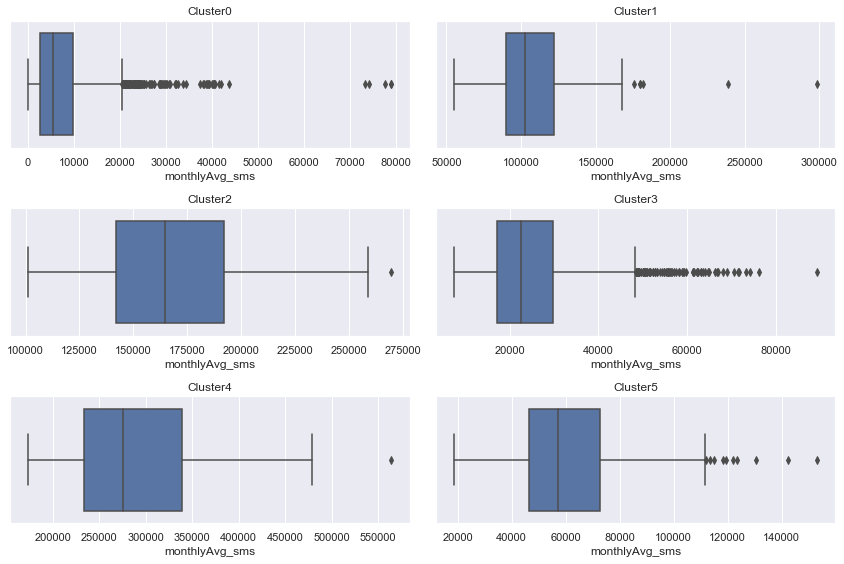

In [76]:
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['monthlyAvg_sms'], ax=ax[0][0])
sns.boxplot(x =Cluster1['monthlyAvg_sms'], ax=ax[0][1])
sns.boxplot(x =Cluster2['monthlyAvg_sms'], ax=ax[1][0])
sns.boxplot(x =Cluster3['monthlyAvg_sms'], ax=ax[1][1])
sns.boxplot(x =Cluster4['monthlyAvg_sms'], ax=ax[2][0])
sns.boxplot(x =Cluster5['monthlyAvg_sms'], ax=ax[2][1])
fig. tight_layout()

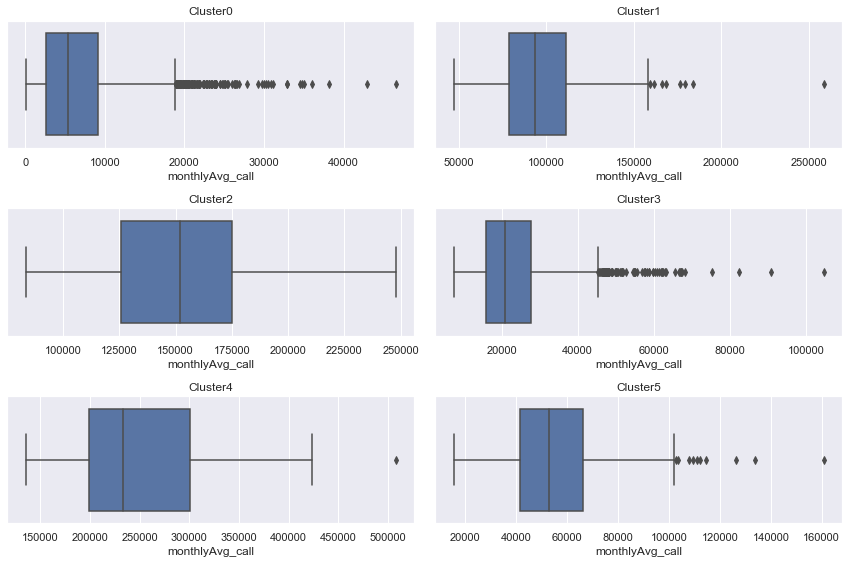

In [77]:
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['monthlyAvg_call'], ax=ax[0][0])
sns.boxplot(x =Cluster1['monthlyAvg_call'], ax=ax[0][1])
sns.boxplot(x =Cluster2['monthlyAvg_call'], ax=ax[1][0])
sns.boxplot(x =Cluster3['monthlyAvg_call'], ax=ax[1][1])
sns.boxplot(x =Cluster4['monthlyAvg_call'], ax=ax[2][0])
sns.boxplot(x =Cluster5['monthlyAvg_call'], ax=ax[2][1])
fig. tight_layout()

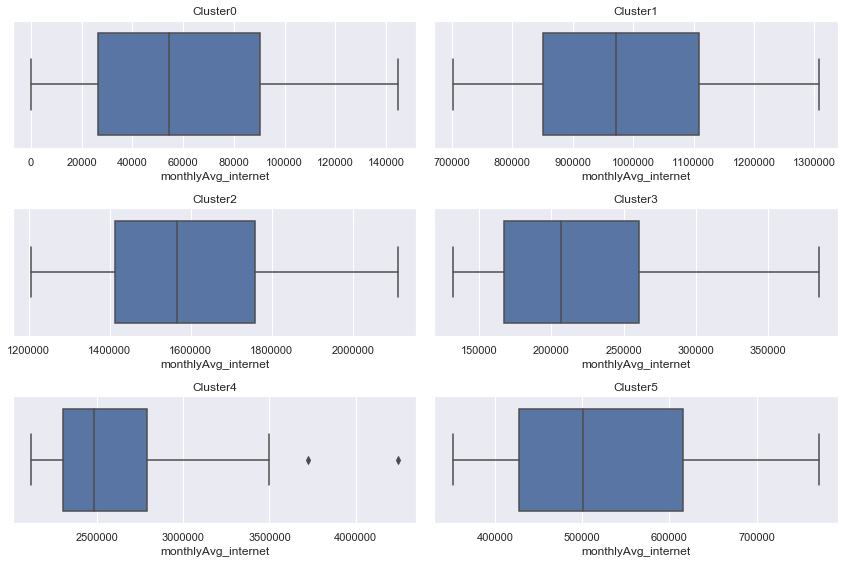

In [78]:
fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=3)
ax[0][0].set_title("Cluster0")
ax[0][1].set_title("Cluster1")
ax[1][0].set_title("Cluster2")
ax[1][1].set_title("Cluster3")
ax[2][0].set_title("Cluster4")
ax[2][1].set_title("Cluster5")

sns.boxplot(x =Cluster0['monthlyAvg_internet'], ax=ax[0][0])
sns.boxplot(x =Cluster1['monthlyAvg_internet'], ax=ax[0][1])
sns.boxplot(x =Cluster2['monthlyAvg_internet'], ax=ax[1][0])
sns.boxplot(x =Cluster3['monthlyAvg_internet'], ax=ax[1][1])
sns.boxplot(x =Cluster4['monthlyAvg_internet'], ax=ax[2][0])
sns.boxplot(x =Cluster5['monthlyAvg_internet'], ax=ax[2][1])
fig. tight_layout()

# Machine Learning 2 -  FORECASTING
We will be forecasting 7 days of daily Internet volumes for grid 5161, which is is very close to Duomo, city center and it generates highest volumes of Internet activity compared to other grids.

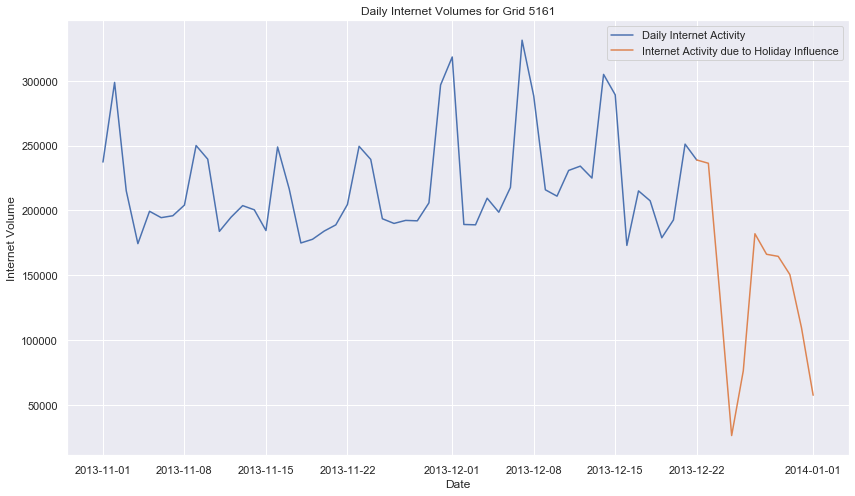

In [79]:
#Time series plot of grid 5161's Daily Internet Activity
pd.plotting.register_matplotlib_converters()

daily5161 = dailyGridActivity.loc[5161]
daily5161Internet = daily5161[['internet']]

daily5161_noHolidays = daily5161Internet.loc['2013-11-01':'2013-12-22']
daily5161_Holiday = daily5161Internet.loc['2013-12-22':]

plt.figure(figsize=(14,8))
plt.plot(daily5161_noHolidays.index, daily5161_noHolidays, label='Daily Internet Activity')
plt.plot(daily5161_Holiday.index, daily5161_Holiday, label='Internet Activity due to Holiday Influence')
plt.title('Daily Internet Volumes for Grid 5161')
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.legend()
plt.show()

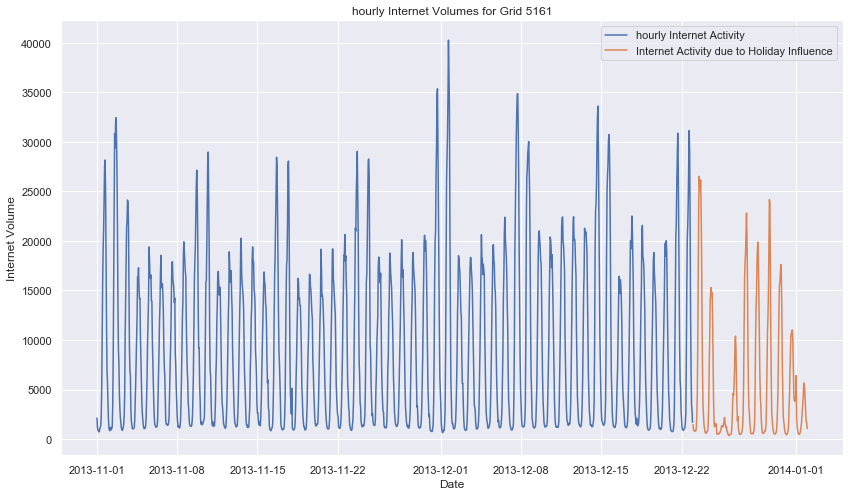

In [80]:
#Time series plot of grid 5161's Hourly Internet Activity
hourly5161 = hourlyGridActivity.loc[5161]
hourly5161Internet = hourly5161[['internet']]

hourly5161_noHolidays = hourly5161Internet.loc['2013-11-01':'2013-12-22']
hourly5161_Holiday = hourly5161Internet.loc['2013-12-23':]

plt.figure(figsize=(14,8))
plt.plot(hourly5161_noHolidays.index, hourly5161_noHolidays, label='hourly Internet Activity')
plt.plot(hourly5161_Holiday.index, hourly5161_Holiday, label='Internet Activity due to Holiday Influence')
plt.title('hourly Internet Volumes for Grid 5161')
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.legend()
plt.show()

## Time Series decomposition

<Figure size 1008x576 with 0 Axes>

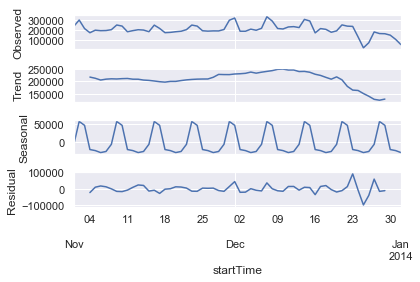

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(daily5161Internet, freq=7)
# Plot decomposed data
plt.figure(figsize=(14,8))
decomp_results.plot() 
plt.show()

## Augmented Dicky fuller test to check for stationarity in trend

In [82]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(daily5161Internet.internet)
results

(-2.1600607165764596,
 0.22105898340125635,
 11,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 1193.4904300056205)

In [83]:
daily5161Internet_diff = daily5161Internet.diff().fillna(0)
results = adfuller(daily5161Internet_diff.internet)
results

(-8.607627828769125,
 6.606378535556466e-14,
 4,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 1196.1746673623513)

1st element is p-value 0.005: p-value < 0.05 means we can reject the null hypothesis of Augmented Dicky fuller test, Dataset is stationary

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1493.622, BIC=1497.844, Fit time=0.044 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1484.144, BIC=1492.587, Fit time=0.034 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1486.837, BIC=1495.280, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1494.886, BIC=1501.219, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 7); AIC=1484.695, BIC=1495.249, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1484.510, BIC=1495.064, Fit time=0.033 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 7); AIC=1486.447, BIC=1499.112, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1482.323, BIC=1488.655, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=1483.887, BIC=1492.330, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

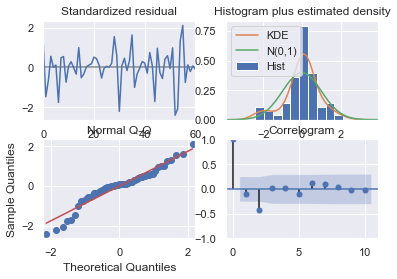

In [84]:
#Import pmdarima package to use its auto_arima() that finds suitable values for SARIMAX parameters
import pmdarima as pm
results = pm.auto_arima(daily5161Internet, start_p=0, max_p=12, d=1,max_d=2, start_q=0, max_q=2, start_P=0, max_P=7, 
                        D=0, max_D=2, start_Q=0, max_Q=2, seasonal=True, m=7,
                        trace=True, error_action='ignore',suppress_warnings=True)
print(results.summary())
results.plot_diagnostics()
plt.show()

In [87]:
#Fit the model on the original dataset
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(daily5161Internet, order=(0,1,0), seasonal_order=(1,0,0,7))
result = model.fit()

/Users/aru/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [88]:
#Forecast daily internet volume values for first week of Januaury
forecast_object = result.get_forecast(steps=7)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

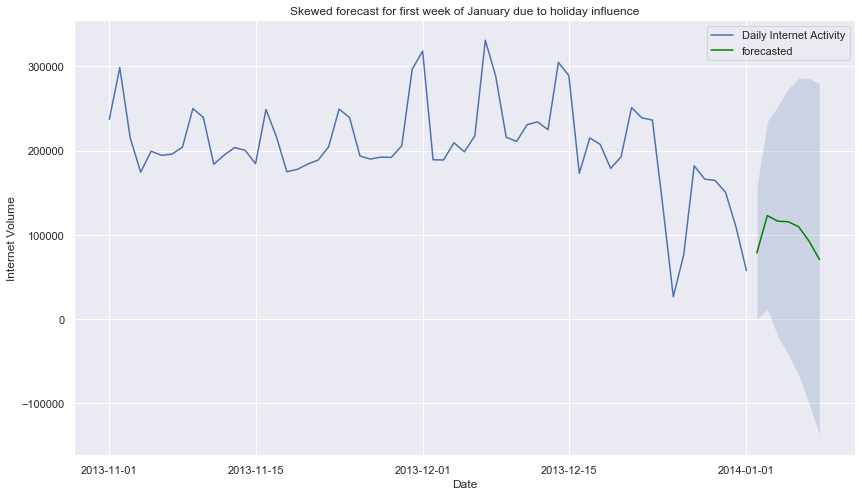

In [89]:
plt.figure(figsize=(14,8))
plt.plot(daily5161Internet.index, daily5161Internet, label='Daily Internet Activity')

# Plot the prediction means as line
plt.plot(mean.index, mean, label='forecasted', color='green')
plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.legend()
plt.title('Skewed forecast for first week of January due to holiday influence')
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.show()

In [90]:
#Display forecasted value for original dataset
skewedForecast = pd.DataFrame(mean)
skewedForecast.columns = ['internet']
skewedForecast['dayOfWeek'] = skewedForecast.index.day_name()
skewedForecast

,internet,dayOfWeek
2014-01-02,78360.396815,Thursday
2014-01-03,122760.994342,Friday
2014-01-04,116108.943688,Saturday
2014-01-05,115435.626308,Sunday
2014-01-06,109543.830285,Monday
2014-01-07,92295.554810,Tuesday
2014-01-08,70439.848225,Wednesday


Text(0, 0.5, 'Internet Volume')

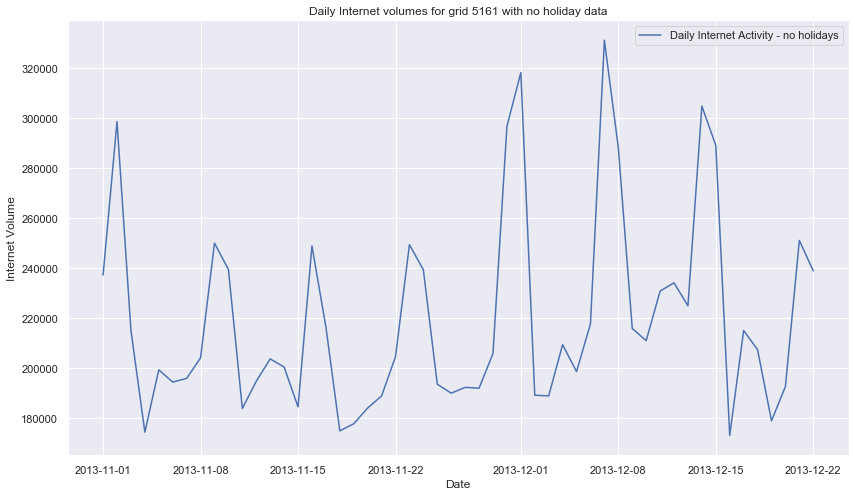

In [91]:
#Time series plot of grid 5161's Daily Internet Activity with data deleted from dec 23, 2013 onwards
#due to its holiday influence
plt.figure(figsize=(14,8))
plt.plot(daily5161_noHolidays.index, daily5161_noHolidays, label='Daily Internet Activity - no holidays')
plt.legend()
plt.title('Daily Internet volumes for grid 5161 with no holiday data')
plt.xlabel('Date')
plt.ylabel('Internet Volume')

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1241.933, BIC=1245.796, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1228.139, BIC=1235.866, Fit time=0.039 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1233.012, BIC=1240.739, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1243.858, BIC=1249.654, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 7); AIC=1228.274, BIC=1237.933, Fit time=0.101 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1226.447, BIC=1236.106, Fit time=0.040 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 2, 7); AIC=1230.234, BIC=1243.756, Fit time=0.140 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=1225.594, BIC=1233.321, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=1227.619, BIC=1237.278, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

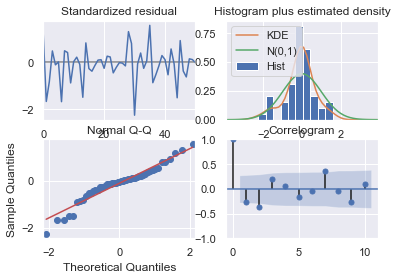

In [92]:
import pmdarima as pm
results = pm.auto_arima(daily5161_noHolidays, start_p=0, max_p=12, d=1,max_d=2, start_q=0, max_q=2, start_P=0, max_P=7, 
                        D=0, max_D=2, start_Q=0, max_Q=2, seasonal=True, m=7,
                        trace=True, error_action='ignore',suppress_warnings=True)
print(results.summary())
results.plot_diagnostics()
plt.show()

In [93]:
model = SARIMAX(daily5161_noHolidays, order=(0,1,0), seasonal_order=(1,0,1,7))
result = model.fit()

/Users/aru/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/aru/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [94]:
#Forecast hoilday data, from dec 23, 2013 till Jan 1, 2014
forecast_object = result.get_forecast(steps=10)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

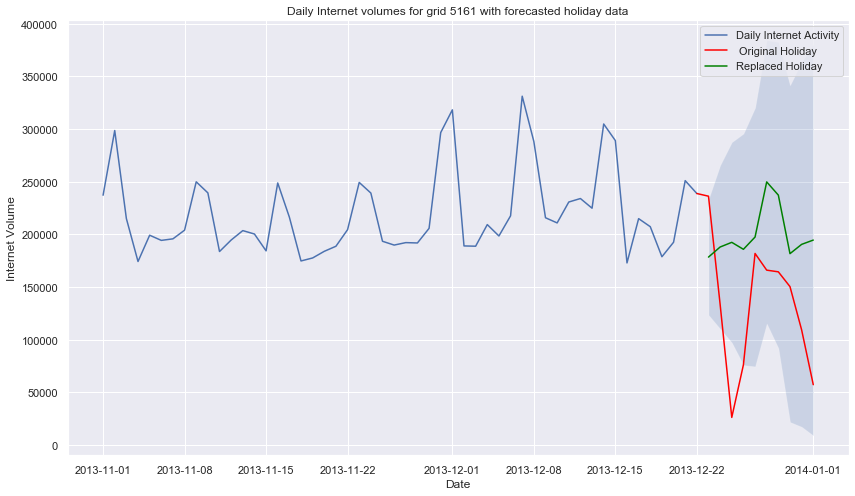

In [95]:

plt.figure(figsize=(14,8))
plt.plot(daily5161_noHolidays.index, daily5161_noHolidays, label='Daily Internet Activity')
plt.plot(daily5161_Holiday.index, daily5161_Holiday, label=' Original Holiday', color='red')
# Plot the prediction means as line
plt.plot(mean.index, mean, label='Replaced Holiday', color='green')
plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.title('Daily Internet volumes for grid 5161 with forecasted holiday data')
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.legend()

In [96]:
daily5161_predictedHoliday = pd.DataFrame(mean)
daily5161_predictedHoliday.columns = ['internet']
daily5161_predictedHoliday['dayOfWeek'] = daily5161_predictedHoliday.index.day_name()
daily5161_predictedHoliday

,internet,dayOfWeek
2013-12-23,178508.373305,Monday
2013-12-24,188075.521499,Tuesday
2013-12-25,192507.131925,Wednesday
2013-12-26,185892.844800,Thursday
2013-12-27,197541.708903,Friday
2013-12-28,249871.132468,Saturday
2013-12-29,237343.944442,Sunday
2013-12-30,181770.646094,Monday
2013-12-31,190579.683204,Tuesday
2014-01-01,194660.128067,Wednesday


In [97]:
#Add the forecasted valumes for Dec 23, 2013 - Jan 1, 2014 period to the dataset
daily5161_New = pd.concat([daily5161_noHolidays[['internet']],daily5161_predictedHoliday[['internet']] ])

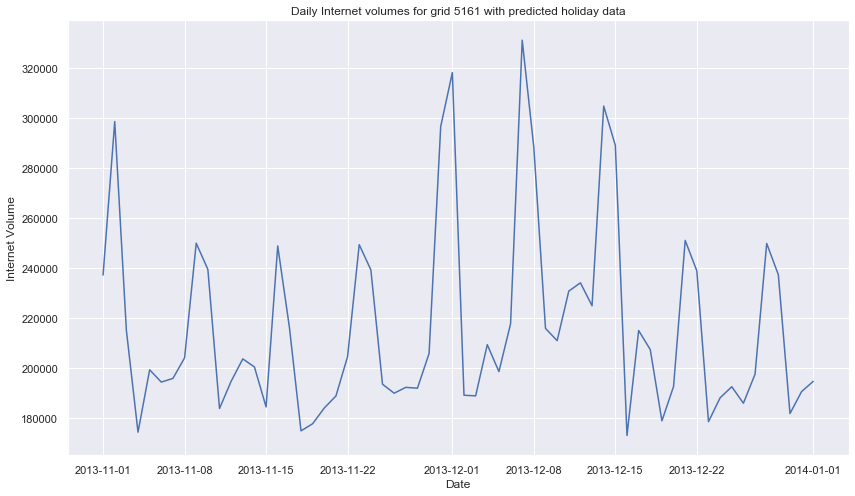

In [98]:
plt.subplots(figsize=(14,8))
plt.plot(daily5161_New.index, daily5161_New)
plt.title('Daily Internet volumes for grid 5161 with predicted holiday data')
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.show()

In [99]:
results = pm.auto_arima(daily5161_New, start_p=0, max_p=12, d=1,max_d=2, start_q=0, max_q=2, start_P=0, max_P=7, 
                        D=0, max_D=2, start_Q=0, max_Q=2, seasonal=True, m=7,
                        trace=True, error_action='ignore',suppress_warnings=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1479.336, BIC=1483.557, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=1459.100, BIC=1467.544, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=1465.860, BIC=1474.303, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=1481.248, BIC=1487.581, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 7); AIC=1458.486, BIC=1469.040, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 7); AIC=1458.525, BIC=1471.190, Fit time=0.060 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 0, 1, 7); AIC=1460.352, BIC=1475.129, Fit time=0.130 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 7); AIC=1457.297, BIC=1465.740, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 0, 7); AIC=1458.041, BIC=1468.596, Fit time=0.067 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   62
Model:             SARIMAX(2, 1, 0)x(1, 0, 1, 7)   Log Likelihood                -713.735
Date:                           Mon, 27 Jan 2020   AIC                           1439.470
Time:                                   20:18:51   BIC                           1452.136
Sample:                                        0   HQIC                          1444.434
                                            - 62                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -946.5647   2473.601     -0.383      0.702   -5794.734    3901.605
ar.L1         -0.0352      0.125     -0.281

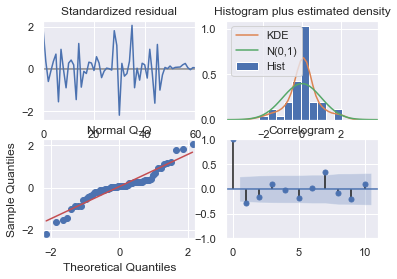

In [100]:
print(results.summary())
results.plot_diagnostics()
plt.show()

In [101]:
#Fit the model for the new dataset
model = SARIMAX(daily5161_New, order=(2,1,0), seasonal_order=(1,0,1,7))
result = model.fit()

/Users/aru/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [102]:
#Predict volumes against our data to check for error
prediction_object = result.get_prediction(start='2013-12-10',end='2013-12-15' ,dynamic=True)
mean = prediction_object.predicted_mean
conf_int = prediction_object.conf_int()
dates = mean.index

from sklearn.metrics import mean_squared_error
from math import sqrt

#Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    #y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_percentage_error(daily5161_New.loc['2013-12-10':'2013-12-15'].internet,mean)
print("MAPE = {}%".format(round(error, 2)))
print("Accuracy = {}%".format(round((100-error),2)))
rms = sqrt(mean_squared_error(daily5161_New.loc['2013-12-10':'2013-12-15'], mean))
print('The Root Mean Squared Error of our prediction is {}'.format(round(rms, 2)))

MAPE = 5.12%
Accuracy = 94.88%
The Root Mean Squared Error of our prediction is 15270.31


In [103]:
#Forecast for the first week of January 2014
forecast_object = result.get_forecast(steps=7)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

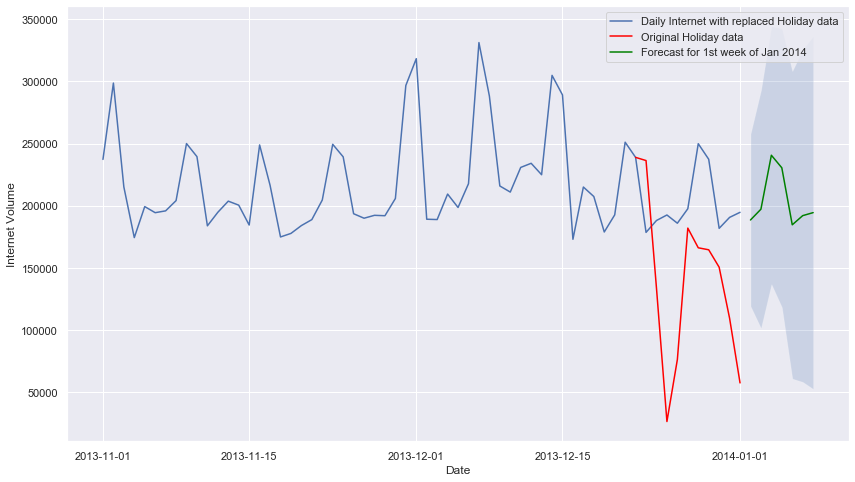

In [104]:
plt.figure(figsize=(14,8))
plt.plot(daily5161_New.index, daily5161_New, label='Daily Internet with replaced Holiday data')
plt.plot(daily5161_Holiday.index, daily5161_Holiday, label='Original Holiday data', color='red')
# Plot the prediction means as line
plt.plot(mean.index, mean, label='Forecast for 1st week of Jan 2014', color='green')
plt.fill_between(mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.legend()
plt.show()

In [105]:
forecastJan = pd.DataFrame(mean)
forecastJan.columns = ['internet']
forecastJan['dayOfWeek'] = forecastJan.index.day_name()
forecastJan

,internet,dayOfWeek
2014-01-02,188492.368833,Thursday
2014-01-03,197161.126424,Friday
2014-01-04,240587.960501,Saturday
2014-01-05,230495.113264,Sunday
2014-01-06,184610.400177,Monday
2014-01-07,191983.028152,Tuesday
2014-01-08,194410.997532,Wednesday


In [106]:
daily5161 = dailyGridActivity.loc[5161]
daily5161Internet = daily5161[['internet']]
df = daily5161Internet.reset_index()
df.columns = ['ds','y']

## FB Prophet

In [107]:
from fbprophet import Prophet
m = Prophet(weekly_seasonality=True,holidays_prior_scale=0.05)
m.add_country_holidays(country_name='Italy')
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [108]:
future = m.make_future_dataframe(periods=7,freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
62,2014-01-02,125991.351077,91671.071959,165191.406532
63,2014-01-03,143136.836457,106942.026819,179966.126277
64,2014-01-04,201952.516073,165978.955364,239575.866443
65,2014-01-05,177927.795940,141447.717185,215487.982292
66,2014-01-06,118780.830024,80861.855510,157549.644373
67,2014-01-07,108425.291950,73696.963886,144950.126645
68,2014-01-08,98430.178749,61245.931351,136063.002399


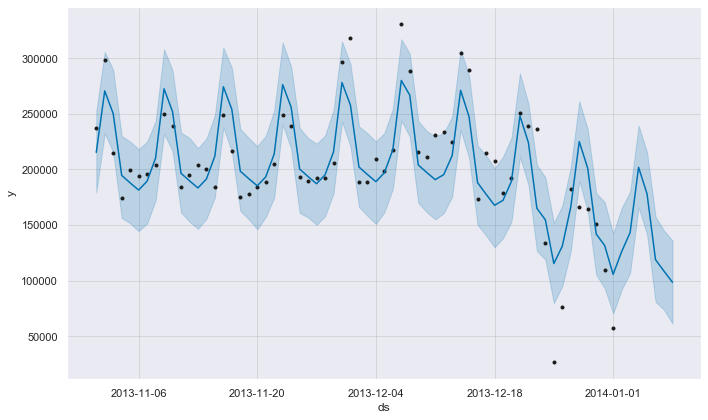

In [109]:
fig1 = m.plot(forecast)